#Outline

1. Importing Libraries
2. Defining Objectives and Metrics
3. Implementing an environment from scratch
4. Implementing a Deep Q-Network Agent from scratch
5. Updating the environment from 1 to 3 dimensions state space
6. Updating the Agent to receive multiple input in the network (from 1 to 3 input neurons)
7. Updating the environment from 3 to 5 dimensions state space
8. Hyperparameters Fine Tuning
9. Leaderboard
10. Conclusions


## Libraries

In [1]:
import random

import gym
from gym import spaces
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

from collections import deque

import torch.nn.functional as F



## Objective , Metrics & Rewards

### Objective

We want to build an agent that chooses among 3 actions according to the state it is :
- hold
- buy
- sell


### Reward

Of course our objective is to earn money over time ! So our metric will be the **cumulated reward over time**.

We define the reward as the following:
- If the agent buys and the stock's value increases, the reward is this increase (eg. reward = +5.98 \$)
- If the agent holds its position , the reward is null.
- If the agent sells and the stock's value increases, the reward is this negative amount (eg. reward = -5.98$)

## Hypothesis of the project

This project as simplistic hypothesis:  

1. The agent are unlimited money : each day , it can buy or sell 1 stock. That means that if it buys for 100 consecutive days stocks around 150 \$, it would have spend 15k \$.
2. We base our learning only on a few states among current_price, volume exchanged during the day, rolling average over the 20 last days, lag -1 (value of the day before), lag -5 (value of the 5-th day before).
3. We base our learning only on 1 stock, the one from Apple.
4. We do not take any external information, such as the market sentiment, GDP, etc... the whole information is extracted from the time series of the stock.
5. The agent can sell stock it doesn't hold : for example, if first 10 actions of the agent are only "sell", the portfolio's value increases with the same amount of money. To overcome this issue, we just have to say that the agent starts with 10k \$ worth of stock and then begins to trade.

## Hyperparameters we will have to tune at the end of the day

Before building anything, let's analyse the whole picture by keeping in mind which hyperparameter we will have to tune.

1. **Learning Rate**: The rate at which the weights of the neural network are updated during training
2. **Discount Factor (Gamma)**: Determines the importance of future rewards in the agent's decision-making process.
3. **Epsilon (Exploration Rate)**: Determines the balance between exploration and exploitation in the agent's action selection strategy.
4. **Batch Size**: The number of samples used in each training iteration.
5. **Replay Memory Size:** The size of the replay memory buffer used for storing past experiences. A larger replay memory size allows the agent to learn from a more diverse set of experiences.
6. **Target Network Update Frequency:** How often the weights of the target network are updated with the weights of the main network.
7. **Network Architecture:** The architecture of the neural network used to approximate the Q-function (hidden size)
8. **Decay Rate**

# Data Import

We will use stock price information from Yahoo Finance.

In [2]:
!pip install yfinance

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Stock Dataframe creation

We create a simple function that retrieves data from Yahoo Finance and store it into a df.

In [3]:
import yfinance as yf
import pandas as pd

def get_stock_data(stock_name, start_date, end_date):
    """Function that creates a DataFrame for a certain stock, in between 2 given dates."""

    data = yf.download(stock_name, start=start_date, end=end_date)

    return data

Our case study : Apple from Jan 2022 to now (march 2024)

In [4]:
symbol = "AAPL"
start_date = "2022-01-01"
end_date = "2024-03-21"

stock_data = get_stock_data(symbol, start_date, end_date)
stock_data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,177.830002,182.880005,177.710007,182.009995,179.724548,104487900
2022-01-04,182.630005,182.940002,179.119995,179.699997,177.443558,99310400
2022-01-05,179.610001,180.169998,174.639999,174.919998,172.723587,94537600
2022-01-06,172.699997,175.300003,171.639999,172.000000,169.840240,96904000
2022-01-07,172.889999,174.139999,171.029999,172.169998,170.008118,86709100


We have various information. We will only work with the closing prices and the volume exchanged.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


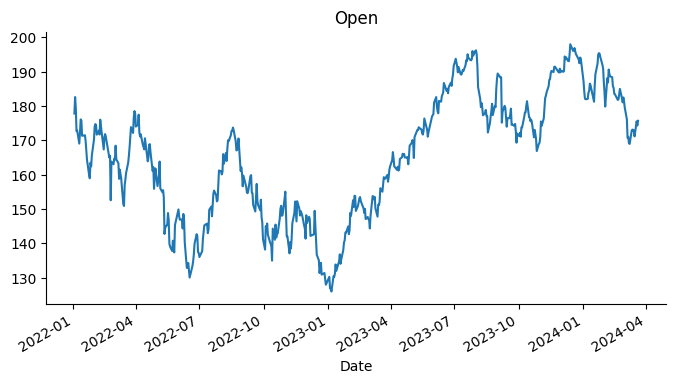

In [5]:
# @title Open prices plot

from matplotlib import pyplot as plt
stock_data['Open'].plot(kind='line', figsize=(8, 4), title='Open')
plt.gca().spines[['top', 'right']].set_visible(False)

# First Environment : only price as state

Let's see if there is an already built-in environment in gymnasium :

In [6]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.1 MB/s eta 0:00:00


In [7]:
import gymnasium
from gym.spaces import Discrete, Box

gymnasium.envs.registry.keys()

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'phys2d/CartPole-v0', 'phys2d/CartPole-v1', 'phys2d/Pendulum-v0', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'tabular/Blackjack-v0', 'tabular/CliffWalking-v0', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4', 'GymV21Environment-v0', 'GymV26Environment-v0'])

It's not the case, so we are going to build a custom one.

We need to define a certain number of methods in our environment :
1. __init__ : method that initializes the ojects in our class
2. **reset**(self): : method that will be called to initiate a new episode, returning a first observation
3. **step**(self, action): : method that usually contains most of the logic of your environment.
4. **render** (optional) : we won't render anything in this project within this class.

## Methods and functions in the class

Let's explicitely and step by step define each class, and then wrap everything into a final class `StockTradingEnv`.

### Init class

We need to define the action space and observation space

The Box class is used to define continuous observation or action spaces, where each dimension can take on any real value within a specified range.
According to the statistics in the data, we can define which ranges are suitable for every dimension:
- price:
- volume:
- etc...

- actions : 3 actions (-1 : sell, 0: hold, +1 : buy)
- observations: only current price

#### Action space

In [8]:
action_space =  Discrete(3)
action_space.sample()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2

#### Observation space

First of all, let's keep in mind that our neural network should have as inputs normalized values. The question is thus : *how would we normalize the price ?*
- To avoid data leakeage, we will thus compute the max and min values on a train set, and then use these values for the test set. Our class will thus have as inputs those statistical values to use an MinMax Scaler.

Moreover, we can wonder what happens if a new state appear : for example a new high ever in the price. If our data is between 0 and $200, what would be impact of a new time high of 210 ?
- Thus, we say that for this project, we stay bounded in the states that aleady exist, that is between the min and max values in the df
- That also mean that we **can simply describe a continuous observation space between 0 and 1**, and **normalize the dataframe to have the corresponding values**.

In [9]:
# Observation space: current price
observation_space = Box(low=0, high=1, shape=(1,))

observation_space.sample()

array([0.9006114], dtype=float32)

In [10]:
def __init__(self, df, min_max_scaler = None):
        super(StockTradingEnv, self).__init__()

        """ Constructor for the StockTradingEnv
        df[DataFrame] : dataframe with index and values """

        # Preprocess data as we will use a NN approach
        self.df = df #storing the df as it we will need its information for reset() and step()
        self.data = df["Close"].values.reshape(-1, 1)
        self.scaler = min_max_scaler

        if min_max_scaler == None : #if we have the training set and thus not scaler
          self.scaler = MinMaxScaler()
          self.data_normalized = self.scaler.fit_transform(self.data)
        else : #a fitter scaler is given, and we only transform
          self.data_normalized = self.scaler.transform(self.data)

        self.state = None

        # Action space: 0 = sell, 1 = hold, 2 = buy
        self.action_space = Discrete(3)

        # Observation space: current price
        self.observation_space = Box(low=0, high=1, shape=(1,))

        #extracting information from all rewards thanks to the function compute_reward_stats
        self.max_reward,self.min_reward= self.compute_reward_stats()

### Reset class

Method that resets the environment to start a new episode.
We can begin wherever we want in the dataframe.

We will use the following line to generate a beginning.

In [11]:
random.randrange(0,len(stock_data))

12

In [12]:
def reset(self):

      """Method to initiate a new episode.
      In our case, we need to define which day is the starting point from our data.
      This method also updates the number of remaining values, as they are needed to end an episode  """

      self.current_step =  random.randrange(0,len(self.df)) #starting index for the current episode that will be updated in step()
      self.num_remaining_values = len(stock_data)-self.current_step #storing the number or remaining epsiodes

      self.state = self.data_normalized[self.current_step]

      return self.state

### Compute reward stats

- Here, when updating the q values, we need every inputs to be normalized, so we also normalize the data.

- To normalize the reward in the step function, we need the maximum and minimum reward ever.

In [13]:
def compute_reward_stats(self):
        """
        This function computes the max, min and standard deviation of daily rewards

        Args:
            df: A pandas DataFrame with a 'value' column

        Returns:
            A dictionary containing the max reward, min reward and standard deviation of rewards
        """
        # Calculate daily rewards (absolute difference between consecutive values)
        rewards = self.df["Close"].diff().abs()

        # Compute max reward, min reward and standard deviation of rewards
        max_reward = rewards.max()
        min_reward = rewards.min()

        return max_reward,min_reward

### Step class

In [14]:
def step(self, action):
        """
        Given an action it returns
        * the next state
        * a reward
        * a status report if the game is over
        * an info dictionary
        """

        # Calculate next state
        self.current_step += 1
        next_state = self.data_normalized[self.current_step] #extracting the next value

        # Calculate reward
        current_price = self.data[self.current_step]
        previous_price = self.data[self.current_step - 1]

        if action == 0: #Sell
          reward = previous_price - current_price
        elif action == 1 : #hold
          reward = 0  # No change in price when holding
        else : #Buy
          reward = current_price - previous_price

        # Normalize the reward
        normalized_reward = (reward-self.min_reward)/(self.max_reward-self.min_reward)

        # Update state
        self.state = next_state

        # Check if episode is done
        done = self.current_step == len(self.df) - 1

        return next_state, normalized_reward, done, {"reward": reward}

### Render class

In [15]:
def render(self, mode='human'):
        pass

## Final Environment Class

In [113]:
class StockTradingEnv(gym.Env):
    def __init__(self, df, min_max_scaler = None, train = True):
        super(StockTradingEnv, self).__init__()

        """ Constructor for the StockTradingEnv
        df[DataFrame] : dataframe with index and values """

        # Preprocess data as we will use a NN approach
        self.df = df #storing the df as it we will need its information for reset() and step()
        self.data = df["Close"].values.reshape(-1, 1)
        self.scaler = min_max_scaler
        self.train = train

        if min_max_scaler == None : #if we have the training set and thus not scaler
          self.scaler = MinMaxScaler()
          self.data_normalized = self.scaler.fit_transform(self.data)
        else : #a fitter scaler is given, and we only transform
          self.data_normalized = self.scaler.transform(self.data)

        self.state = None

        # Action space: 0 = sell, 1 = hold, 2 = buy
        self.action_space = Discrete(3)

        # Observation space: current price
        self.observation_space = Box(low=0, high=1, shape=(1,))

        #extracting information from all rewards thanks to the function compute_reward_stats
        self.max_reward,self.min_reward= self.compute_reward_stats()

    def reset(self):

      """Method to initiate a new episode.
      In our case, we need to define which day is the starting point from our data. """

      if self.train == True : #we start randomly in the data set only in the training phase
        self.current_step =  random.randrange(0,len(self.df)) #starting index for the current episode that will be updated in step()
      else : #in the test set, we begin from 0
        self.current_step=0

      self.num_remaining_values = len(stock_data)-self.current_step #storing the number or remaining epsiodes
      self.state = self.data_normalized[self.current_step][0]

      return self.state

    def compute_reward_stats(self):
        """
        This function computes the max, min and standard deviation of daily rewards

        Args:
            df: A pandas DataFrame with a 'value' column

        Returns:
            A dictionary containing the max reward, min reward and standard deviation of rewards
        """
        # Calculate daily rewards (absolute difference between consecutive values)
        rewards = self.df["Close"].diff().abs()

        # Compute max reward, min reward and standard deviation of rewards
        max_reward = rewards.max()
        min_reward = rewards.min()

        return max_reward,min_reward


    def step(self, action):
        """
        Given an action it returns
        * an observations
        * a reward
        * a status report if the game is over
        * an info dictionary
        """

        # Calculate next state
        self.current_step += 1

        try:
          next_state = self.data_normalized[self.current_step] #extracting the next value

          # Calculate reward
          current_price = self.data[self.current_step][0] #we take the non normalized value to compute the reward
          previous_price = self.data[self.current_step - 1][0]

          if action == 0: #Sell
            reward = previous_price - current_price
          elif action == 1 : #hold
            reward = 0  # No change in price when holding
          else : #Buy
            reward = current_price - previous_price

          # Normalize the reward
          normalized_reward = (reward-self.min_reward)/(self.max_reward-self.min_reward)
        except:
          # Update state
          next_state=self.data_normalized[self.current_step-1]
          self.state = next_state

        # Check if episode is done
        done = self.current_step == len(self.df) - 1

        return next_state[0], normalized_reward, done, {"reward": reward}

    def render(self, mode='human'):
        pass

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Example Usage

In [114]:
# Create custom Gym environment
env = StockTradingEnv(stock_data)

# Example usage
obs = env.reset()
print("First observation", obs, "on day", env.current_step , "out of ", len(stock_data))
print(f"There are {env.num_remaining_values} remaining values in the df. ")

for _ in range(5):
    print("\n")

    action = env.action_space.sample()  # Random action for demonstration
    print("Action taken", action)

    next_obs, reward, done, info_dict = env.step(action)
    print("next_obs: ", next_obs, ",normalized reward: ", reward, ",done: ", done, ",Reward", info_dict["reward"])

    if done:
        break

First observation 0.6158161129171205 on day 162 out of  556
There are 394 remaining values in the df. 


Action taken 0
next_obs:  0.5281159718009911 ,normalized reward:  0.5341669718424479 ,done:  False ,Reward 6.410003662109375


Action taken 2
next_obs:  0.4974689597228743 ,normalized reward:  -0.18666585286458334 ,done:  False ,Reward -2.239990234375


Action taken 0
next_obs:  0.46367499219471964 ,normalized reward:  0.20583343505859375 ,done:  False ,Reward 2.470001220703125


Action taken 2
next_obs:  0.44055278191049685 ,normalized reward:  -0.14083353678385416 ,done:  False ,Reward -1.69000244140625


Action taken 0
next_obs:  0.4506773605532246 ,normalized reward:  -0.06166712443033854 ,done:  False ,Reward -0.7400054931640625


# DQN Agent

## Concepts

We need to build a network and then the agent based on this network

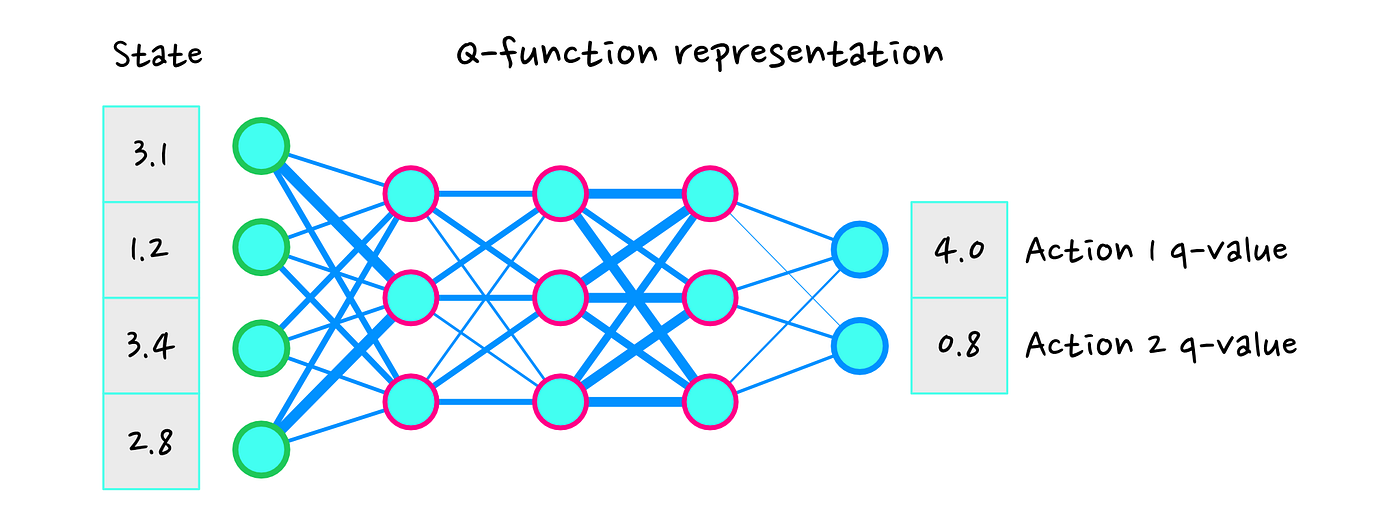

### 2 Separate networks

Here, when building the agent, we have 2 separate networks :

1. **Main Q-Network**: The main Q-network (also known as the online network) is the primary neural network that is being trained to approximate the Q-function. It takes the state as input and outputs Q-values for each action.

2. **Target Q-Network**: The target Q-network is a copy of the main Q-network that is periodically updated to match the parameters of the main network. Initially, the target network is set to be identical to the main network.

- **Fixed Q-Targets:** During training, the target Q-network is used to compute the target Q-values for updating the main Q-network. These target Q-values are "fixed" for a certain number of steps or episodes before being updated again.

- **Stabilizing Training:** By using a separate target network to compute target Q-values, the training process becomes more stable. It helps prevent oscillations or divergence during training, which can occur when using the same network to compute both current and target Q-values.

- **Periodic Update:** The target network is updated periodically by copying the parameters from the main network. This update frequency can be a fixed number of steps or episodes, ensuring that the target network remains relatively stable throughout training.

### Replay Memory

Replay memory, also known as experience replay, is a data structure used in reinforcement learning algorithms, particularly in Deep Q-Networks (DQN), **to store and sample experiences for training**. The main purpose of replay memory is to **break the temporal correlations between consecutive samples and stabilize the training process.**

- **Experience Storage**: During interaction with the environment, the agent collects experiences in the form of tuples (state, action, reward, next state, done). These experiences represent the agent's interactions with the environment and are stored in the replay memory buffer.

- **Buffer Size**: Replay memory has a fixed capacity, determined by the maximum number of experiences it can store. Once the buffer is full, new experiences overwrite the oldest experiences in a first-in-first-out (FIFO) manner.

- **Random Sampling**: During training, the agent samples a minibatch of experiences from the replay memory buffer. Randomly sampling experiences from the buffer breaks the temporal correlations between consecutive samples and reduces the variance of the training process.

- **Training Efficiency**: By storing and sampling experiences from replay memory, the agent can learn from past experiences multiple times, leading to more efficient and stable training. This helps prevent the agent from getting stuck in local optima or forgetting important experiences.

- **Batch Size**: The size of the minibatch sampled from replay memory during each training iteration is typically fixed and determined by the batch size hyperparameter.

- **Prioritized Experience Replay:** In some cases, prioritized experience replay techniques are used to assign different probabilities to experiences based on their importance or relevance. This allows the agent to focus more on experiences that are more informative or challenging.

## Network modeling

We define a simple model.

Here, state size is 1 (we only have the current price) and action size is 3.

In [115]:
# Define Q-Network

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size,hidden_size=32):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x.unsqueeze(1)))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## DQN Agent Class

In [116]:
class DQNAgent:

    """DQN Agent"""

    def __init__(self,state_size, action_size,hidden_size, device,nn_learning_rate = 0.0001):

        self.q_network = QNetwork(state_size=state_size,action_size=action_size,hidden_size=hidden_size).to(device) #instanciation of the main network
        self.target_network = QNetwork(state_size=state_size,action_size=action_size,hidden_size=hidden_size).to(device) #instanciation of the target network

        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=nn_learning_rate)
        self.memory = []  # Replay memory

        self.action_size = action_size

        self.device = device

    def select_action(self, state, epsilon):

        #issues conversion
        if isinstance(state, (float, int)):
          state = torch.tensor([[state]], dtype=torch.float32)  # Reshape to [batch_size, input_size]
        elif isinstance(state, np.ndarray):
            state = torch.from_numpy(state).float()  # Assuming state is already shaped correctly
            state = torch.unsqueeze(state, 0)  # Reshape to [batch_size, input_size]

        # Epsilon-greedy action selection
        if np.random.rand() < epsilon:
            return np.random.randint(self.action_size)
        else:
            with torch.no_grad():

                state = state.clone().detach().to(self.device)

                q_values = self.q_network(state)#running through the model
                return torch.argmax(q_values).item() #selection the action with the highest q value

    def train(self, batch_size, gamma):

        if len(self.memory) < batch_size:
            return

        # Sample a minibatch from replay memory

        memory_indices = list(range(len(self.memory)))
        chosen_indices = np.random.choice(memory_indices, batch_size, replace=False)
        minibatch = [self.memory[i] for i in chosen_indices]

        states, actions, rewards, next_states, dones = zip(*minibatch) #deccorelate everyone in its own array

        # Convert to tensors
        states = torch.tensor(states, dtype=torch.float32).to(self.device ) #size of batch size
        actions = torch.tensor(actions, dtype=torch.int64).to(self.device )
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device )
        dones = torch.tensor(dones, dtype=torch.bool).to(self.device)

        # Compute Q-values

        q_values = self.q_network(states)
        q_values = q_values.gather(1, actions.unsqueeze(1))

        # Compute target Q-values
        with torch.no_grad():
            target_q_values_next = self.target_network(next_states).max(1)[0].detach().to(self.device)
            target_q_values = rewards + (gamma * target_q_values_next * (1 - dones.logical_not().float()))


        # Compute loss
        loss = nn.functional.mse_loss(q_values, target_q_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

## Training loop function

In the context of training a DQN agent, updating the target network too frequently can lead to instability in training, while updating it too infrequently can slow down learning. A common practice is to update the target network periodically after a certain number of steps or episodes.

1. **Learning Rate**: The rate at which the weights of the neural network are updated during training
2. **Discount Factor (Gamma)**: Determines the importance of future rewards in the agent's decision-making process.
3. **Epsilon (Exploration Rate)**: Determines the balance between exploration and exploitation in the agent's action selection strategy.
4. **Batch Size**: The number of samples used in each training iteration.
5. **Replay Memory Size:** The size of the replay memory buffer used for storing past experiences. A larger replay memory size allows the agent to learn from a more diverse set of experiences.
6. **Target Network Update Frequency:** How often the weights of the target network are updated with the weights of the main network.
7. **Network Architecture:** The architecture of the neural network used to approximate the Q-function.

In [117]:
def training_DQN_agent(train_env, test_env,hidden_size, state_size, action_size, device,nn_learning_rate,num_episodes,initial_epsilon, decay_rate, batch_size, gamma, target_update_frequency):
    """
    Function to train a reinforcement learning agent using Deep Q-Networks (DQN).

    Parameters:
        train_env (gym.Env): The training environment.
        test_env (gym.Env): The testing environment.
        hidden_size (int): The size of the hidden layer in the neural network.
        state_size (int): The size of the state space.
        action_size (int): The size of the action space.
        device (str): The device to run the computation on ('cpu' or 'cuda').
        nn_learning_rate (float): The learning rate for the neural network optimizer.
        num_episodes (int): The number of episodes to train the agent.
        initial_epsilon (float): The initial value of epsilon for epsilon-greedy exploration.
        decay_rate (float): The rate at which epsilon decays over episodes.
        batch_size (int): The batch size used for training the agent.
        gamma (float): The discount factor for future rewards in the Q-learning update.
        target_update_frequency (int): The frequency at which to update the target Q-network.

    Returns:
        agent (DQNAgent): The trained DQN agent.
        episodes_rewards (list): A list containing the total rewards obtained during training.
        total_test_reward (float): The total reward obtained during testing.
    """

    agent = DQNAgent(state_size=state_size, hidden_size=hidden_size,action_size=action_size, device=device)
    print("Model architecture : ")
    print(agent.q_network)
    print('\n')

    episodes_rewards = []  # List to store total rewards for each episode
    for episode in tqdm(range(num_episodes)):
        state = train_env.reset()
        total_reward = 0
        epsilon = initial_epsilon

        for step in range(env.num_remaining_values-1): #maximum number of steps per episode

            epsilon = max(epsilon, initial_epsilon - decay_rate * episode)

            action = agent.select_action(state, epsilon)
            #print("step:", train_env.current_step)
            next_state, reward, done, info_dict = train_env.step(action)

            total_reward +=  info_dict["reward"]
            agent.memory.append((state, action, reward, next_state, done))

            state = next_state

            #agent.train(batch_size, gamma) #the agent is trained after each step

            if done:
                break

        agent.train(batch_size, gamma) #the agent is trained after each episode

        if episode % target_update_frequency == 0:
            agent.update_target_network()

        episodes_rewards.append(total_reward)  # Store the total reward for this episode

    #after training, evaluating the cumulative reward over time
    total_train_rewards = []
    total_train_reward=0

    train_env.train = False #we enforce the environment to begin at the first row, to have current_step = 0
    state = train_env.reset()

    while True :
      action = agent.select_action(state, epsilon=0)  # Greedy action selection during testing
      next_state, reward, done, info_dict = train_env.step(action)
      total_train_reward += info_dict["reward"]
      total_train_rewards.append(total_train_reward)
      state = next_state
      if done:
            break

    # Testing the trained agent
    total_test_rewards = []
    total_test_reward=0
    state = test_env.reset()

    while True:
        action = agent.select_action(state, epsilon=0)  # Greedy action selection during testing
        next_state, reward, done, info_dict = test_env.step(action)
        total_test_reward += info_dict["reward"]
        total_test_rewards.append(total_test_reward)
        state = next_state
        if done:
            break

    return agent,episodes_rewards,total_train_rewards, total_test_rewards


In [118]:
stock_data_train  = stock_data[:int(len(stock_data)*0.8)]
stock_data_test  = stock_data[int(len(stock_data)*0.8):]

train_env = StockTradingEnv(stock_data_train, min_max_scaler = None, train = True)
test_env = StockTradingEnv(stock_data_test, min_max_scaler = train_env.scaler, train = False)

state_size= 1 #only current price
action_size= env.action_space.n

hidden_size=16
nn_learning_rate=0.001
num_episodes=100
initial_epsilon=0.4 #Typical values: 0.1 to 0.5
decay_rate=0.9
batch_size=16 #Typical values: 32 to 256
gamma=0.99 #Typical values: 0.95 to 0.99
target_update_frequency=20 #Typical values: 1000 to 10000 (number of steps)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trained_agent,episodes_rewards,train_rewards,test_rewards=training_DQN_agent(train_env=train_env,
                                         test_env=test_env,
                                         hidden_size=hidden_size,
                                        state_size=state_size,
                                        action_size=action_size,
                                        device=device,
                                        nn_learning_rate=nn_learning_rate,
                                        num_episodes=num_episodes,
                                        initial_epsilon=initial_epsilon,
                                        decay_rate=decay_rate,
                                        batch_size=batch_size,
                                        gamma=gamma,
                                        target_update_frequency=target_update_frequency)

Model architecture : 
QNetwork(
  (fc1): Linear(in_features=1, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=3, bias=True)
)




100%|██████████| 100/100 [00:05<00:00, 19.19it/s]


In [119]:
len(trained_agent.memory)

21040

And we can make a prediction :

In [120]:
trained_agent.q_network(torch.tensor([0.23]).to(device))

tensor([[-0.0132, -0.0784,  0.0721]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

## Plotting prediction function

In [121]:
def compute_maximum_earning(df):
    """
    Compute the maximum cumulated reward over time based on the given dataframe.

    Parameters:
        df (DataFrame): The dataframe containing price data.

    Returns:
        list: A list of maximum cumulated rewards over time.
    """
    max_earning = 0
    max_earning_list = []

    for i in range(1, len(df)):
        previous_price = df.iloc[i - 1]['Close']
        current_price = df.iloc[i]['Close']

        reward = np.abs(current_price - previous_price)
        max_earning+=reward
        max_earning_list.append(max_earning)

    return max_earning_list

In [122]:
def plot_predicted_values(episodes_rewards, train_rewards, test_rewards, train_df, test_df, max_display = False, log_y = False):

    ## CUMULATIVE REWARD OVER EPISODES ##

    # Plot cumulative reward versus num episode for training phase
    num_episodes = len(episodes_rewards)
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    if max_display == True :
      max_train_earning = compute_maximum_earning(train_df)[-1]
      plt.plot([0,num_episodes], [max_train_earning,max_train_earning], color="black", label="Maximum Cumulative Earning")

    plt.plot(np.arange(1, num_episodes + 1), episodes_rewards)
    plt.plot([0,num_episodes], [0,0], color="green")

    if log_y == True :
      plt.yscale("log")

    # Calculate rolling average for episode rewards
    episode_rolling_avg = pd.Series(episodes_rewards).rolling(window=int(len(episodes_rewards)/10)).mean()

    # Plot rolling average for train rewards
    plt.plot(episode_rolling_avg, color='red', label='Rolling Average (Last 10 Episodes)')
    plt.legend(loc='upper left')

    # Annotate the last value of the train reward
    last_episode_reward = episodes_rewards[-1]
    plt.text(num_episodes, np.max(episodes_rewards), f'Final Episode Earning: {episodes_rewards[-1]:.2f}$', ha='right', color='red')

    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Reward vs. Episode (Training Phase)')
    plt.grid(True)

    ## CUMULATIVE REWARD OVER TIME ##

    plt.subplot(1, 2, 2)

    # Plot cumulative reward over time for both training and testing phases
    plt.plot(np.arange(1, len(train_rewards) + 1), train_rewards, label='Train Phase')
    plt.plot(np.arange(len(train_rewards) + 1, len(train_rewards) + 1 + len(test_rewards)), test_rewards, label='Test Phase')

    # Annotate the last value of the train reward and test reward
    plt.text(len(train_rewards), np.max(train_rewards), f'Final Train Earning: {train_rewards[-1]:.2f}$', ha='right', color='red')
    plt.text(len(train_rewards) + len(test_rewards), np.max(test_rewards), f'Final Test Earning: {test_rewards[-1]:.2f}$', ha='right', color='red')

    if max_display == True :
      # Compute and plot the maximum possible earning for the training phase
      max_train_earning = compute_maximum_earning(train_df)
      plt.plot(np.arange(1, len(train_df)), max_train_earning, linestyle='--', color='blue', label='Max Train Earning')

      # Compute and plot the maximum possible earning for the testing phase
      max_test_earning = compute_maximum_earning(test_df)
      plt.plot(np.arange(len(train_rewards) + 1, len(train_rewards) + len(test_rewards)+1), max_test_earning, linestyle='--', color='orange', label='Max Test Earning')

    plt.xlabel('Time (Days)')
    plt.ylabel('Cumulative Reward')
    if log_y == True :
      plt.yscale("log")
    plt.title('Cumulative Reward over Time')
    plt.axvspan(len(train_rewards) + 1, len(train_rewards) + len(test_rewards), color='orange', alpha=0.3)
    plt.plot([0,len(train_rewards) + len(test_rewards)], [0,0], color="green")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

### 100 episodes, 16 hidden size

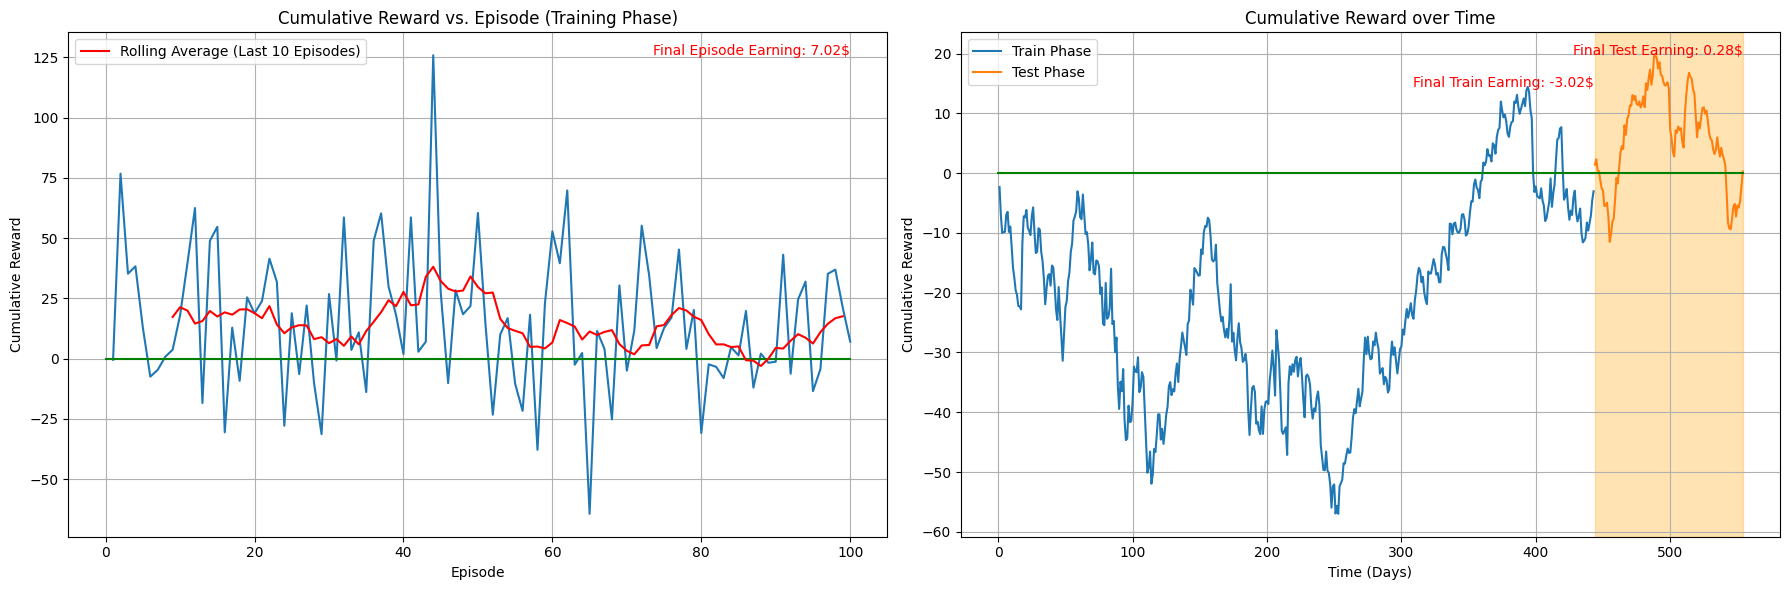

In [123]:
plot_predicted_values(episodes_rewards, train_rewards, test_rewards, stock_data_train, stock_data_test,max_display=False, log_y = False)

### 1K episodes, 16 hidden size

In [124]:
num_episodes=1000
hidden_size=16
trained_agent,episodes_rewards,train_rewards,test_rewards=training_DQN_agent(train_env=train_env,
                                         test_env=test_env,
                                         hidden_size=hidden_size,
                                        state_size=state_size,
                                        action_size=action_size,
                                        device=device,
                                        nn_learning_rate=nn_learning_rate,
                                        num_episodes=num_episodes,
                                        initial_epsilon=initial_epsilon,
                                        decay_rate=decay_rate,
                                        batch_size=batch_size,
                                        gamma=gamma,
                                        target_update_frequency=target_update_frequency)

Model architecture : 
QNetwork(
  (fc1): Linear(in_features=1, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=3, bias=True)
)




100%|██████████| 1000/1000 [01:47<00:00,  9.32it/s]


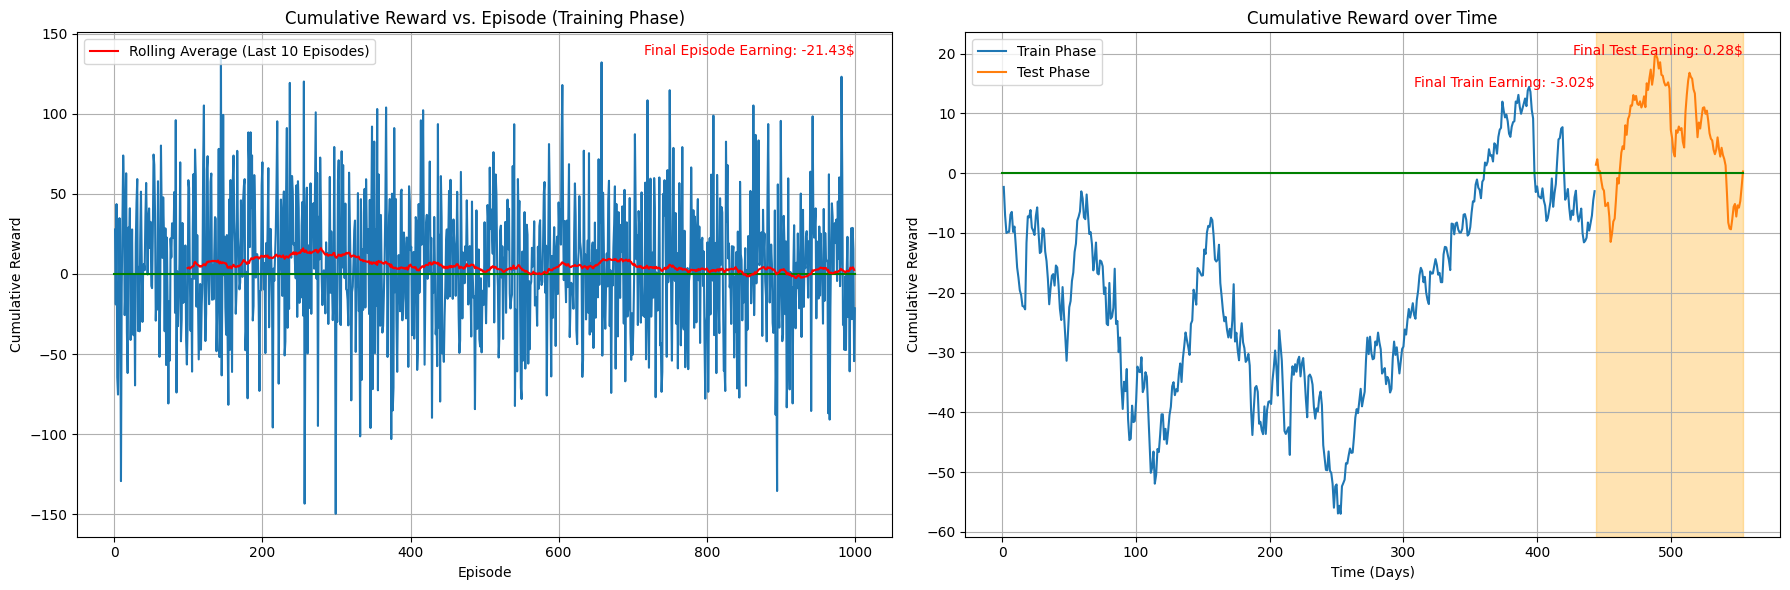

In [125]:
plot_predicted_values(episodes_rewards, train_rewards, test_rewards, stock_data_train, stock_data_test,max_display=False, log_y = False)

### 1K episodes, 128 hidden size

In [126]:
num_episodes=1000
hidden_size=128
target_update_frequency=100

trained_agent,episodes_rewards,train_rewards,test_rewards=training_DQN_agent(train_env=train_env,
                                         test_env=test_env,
                                         hidden_size=hidden_size,
                                        state_size=state_size,
                                        action_size=action_size,
                                        device=device,
                                        nn_learning_rate=nn_learning_rate,
                                        num_episodes=num_episodes,
                                        initial_epsilon=initial_epsilon,
                                        decay_rate=decay_rate,
                                        batch_size=batch_size,
                                        gamma=gamma,
                                        target_update_frequency=target_update_frequency)

Model architecture : 
QNetwork(
  (fc1): Linear(in_features=1, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
)




100%|██████████| 1000/1000 [01:51<00:00,  8.97it/s]


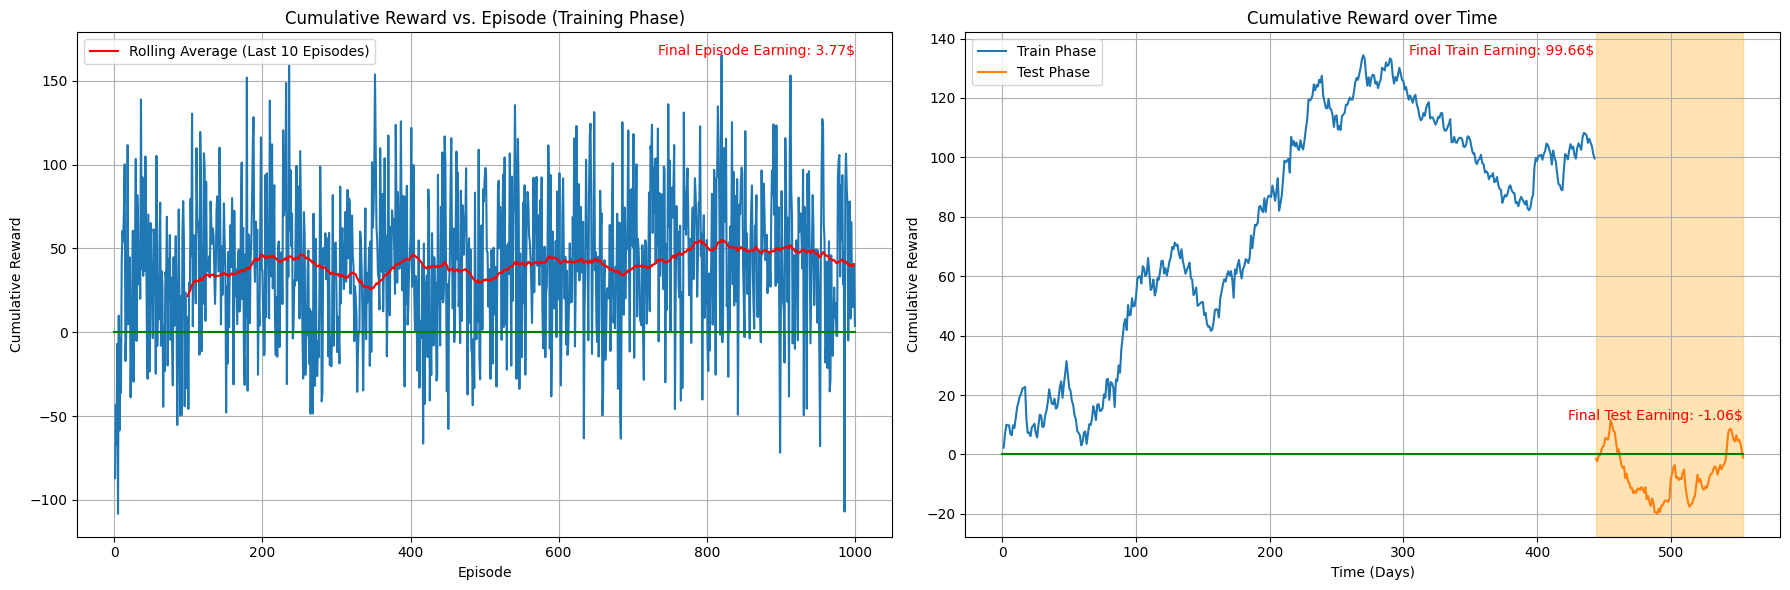

In [127]:
plot_predicted_values(episodes_rewards, train_rewards, test_rewards, stock_data_train, stock_data_test,max_display=False, log_y = False)

## Conclusion on the first environment

As we could expect, knowing only the price is not enough information. The agent tries to learn on the train set, but the variance of cumulative reward is way to high. Obviously, the results on the test set look like a random walk.

# Second iteration: increasing space state and updated env.

## Environment Class 2 :state = {current price, volume of transaction, window mean value}

Here, we need to defined a new function get_state() that computes information from the dataframe.

In [128]:
class StockTradingEnv2(gym.Env):
    def __init__(self, df,last_n_days=5, price_scaler=None, volume_scaler=None, train = True):
        super(StockTradingEnv2, self).__init__()

        """ Constructor for the StockTradingEnv2
        df[DataFrame] : dataframe with index and values
        last_n_days[int] : number of days we take into account to compute the moving average """

        # Preprocess data as we will use a NN approach
        self.df = df #storing the df as it we will need its information for reset() and step()
        self.train = train

        self.close = df["Close"].values.reshape(-1, 1)
        self.volume = df["Volume"].values.reshape(-1, 1)

        self.close_scaler=price_scaler
        self.volume_scaler=volume_scaler

        if price_scaler==None : #if we are in the train preprocessing

          self.close_scaler = MinMaxScaler() #2 different scaler because we reuse the price scaler after on the moving average
          self.volume_scaler = MinMaxScaler()

          self.close_normalized = self.close_scaler.fit_transform(self.close)
          self.volume_normalized = self.volume_scaler.fit_transform(self.volume)

        else :
          self.close_normalized = self.close_scaler.transform(self.close)
          self.volume_normalized = self.volume_scaler.transform(self.volume)

        self.max_reward,self.min_reward= self.compute_reward_stats() #extracting info from the whole df about rewards

        self.state = None
        self.last_n_days = last_n_days

        # Action space: 0 = sell, 1 = hold, 2 = buy
        self.action_space = Discrete(3)

        # Observation space: current price,volume,mean
        self.observation_space = Box(low=0, high=1, shape=(3,))

    def reset(self):

      """Method to initiate a new episode.
      In our case, we need to define which day is the starting point from our data. """

      if self.train == True : #we start randomly in the data set only in the training phase
        self.current_step =  random.randrange(0,len(self.df)) #starting index for the current episode that will be updated in step()
      else : #in the test set, we begin from 0
        self.current_step=0

      self.num_remaining_values = len(stock_data)-self.current_step #storing the number or remaining epsiodes

      # Initialize reward statistics (optional)
      self.reward_mean = 0.0
      self.reward_std = 1.0  # Avoid division by zero initially
      self.count_step = 0 #to udpate the reward mean (is different than current step)

      return self.get_state()

    def get_moving_average(self):
      """ Function that computes the mean of prices for the last n days, and then normalize this value"""

      # Computing the mean of the previous values, and then normalizing this mean
      if self.current_step >= self.last_n_days: #case we have enough day before to compute the mean

          # Extract the last n days of close prices
          price_last_n_days = self.close[self.current_step - self.last_n_days + 1:self.current_step + 1]

          # Compute the mean of the last n days
          moving_average = np.mean(price_last_n_days)

          # Normalize the mean using the same scaler
          normalized_moving_average = self.close_scaler.transform(np.array(moving_average).reshape(-1, 1))

      else:
          # If there are not enough previous days, use the current price as the mean
          normalized_moving_average = [self.close_normalized[self.current_step]]


      return normalized_moving_average[0][0]


    def compute_reward_stats(self):
        """
        This function computes the max, min and standard deviation of daily rewards

        Args:
            df: A pandas DataFrame with a 'value' column

        Returns:
            A dictionary containing the max reward, min reward and standard deviation of rewards
        """
        # Calculate daily rewards (absolute difference between consecutive values)
        rewards = self.df["Close"].diff().abs()

        # Compute max reward, min reward and standard deviation of rewards
        max_reward = rewards.max()
        min_reward = rewards.min()

        return max_reward,min_reward

    def get_state(self):
      # Get the current state representation



      current_price = self.close_normalized[self.current_step][0] #getting the normalized price
      current_volume = self.volume_normalized[self.current_step][0] # getting the normalized volume
      normalized_price_mean_last_n_days = self.get_moving_average()

      return current_price, current_volume, normalized_price_mean_last_n_days

    def step(self, action):

        """
        Given an action it returns
        * an observation
        * a reward
        * a status report if the game is over
        * an info dictionary
        """

        # Calculate next state

        self.current_step += 1
        self.count_step+=1
        next_state = self.get_state() # 3 values to unpack

        # Calculate reward
        current_price = self.close[self.current_step][0] #we take the non normalized value to compute the reward
        previous_price = self.close[self.current_step - 1][0]

        if action == 0: #Sell
          reward = previous_price - current_price
        elif action == 1 : #hold
          reward = 0  # No change in price when holding
        else : #Buy
          reward = current_price - previous_price

        # Normalize the reward
        normalized_reward = (reward-self.min_reward)/(self.max_reward-self.min_reward)

        # Update state
        self.state = next_state

        # Check if episode is done
        done = self.current_step == len(self.df) - 1

        return next_state, normalized_reward, done, {"reward": reward}

    def render(self, mode='human'):
        pass

### Example Usage

In [129]:
# Create custom Gym environment
env = StockTradingEnv2(stock_data)


# Example usage
obs = env.reset()
print("First observation", obs, "on day", env.current_step , "out of ", len(stock_data))
print(f"There are {env.num_remaining_values} values in the df. ")

for _ in range(5):
    print("\n")

    action = env.action_space.sample()  # Random action for demonstration
    print("Action taken", action)

    next_obs, reward, done, _ = env.step(action)
    print("next_obs: ", next_obs, "normalized reward: ", reward, "done: ", done, _)

    if done:
        break

First observation (0.5805171432767648, 0.25914059400695155, 0.5980845199916953) on day 334 out of  556
There are 222 values in the df. 


Action taken 1
next_obs:  (0.5578053691352232, 0.3606796940090329, 0.5909152485899607) normalized reward:  0.0 done:  False {'reward': 0}


Action taken 2
next_obs:  (0.6642496654246066, 0.563014928065381, 0.6015596990956105) normalized reward:  0.6483345031738281 done:  False {'reward': 7.7800140380859375}


Action taken 1
next_obs:  (0.6632918419136093, 0.20128511665133011, 0.612258846584669) normalized reward:  0.0 done:  False {'reward': 0}


Action taken 2
next_obs:  (0.6396224530281829, 0.13420437366015428, 0.6210972945556772) normalized reward:  -0.14416631062825522 done:  False {'reward': -1.7299957275390625}


Action taken 0
next_obs:  (0.6641127141989716, 0.18716813294170995, 0.6378164087401188) normalized reward:  -0.14916610717773438 done:  False {'reward': -1.7899932861328125}


## Agent2 : multiple input for increased space state

We build an other agent and an other training loop as going from 1 input (price only) to multiple (price, volume, average) is not compatible in terms of dimensions with resizing etc.

In [130]:
# Define Q-Network

class QNetwork2(nn.Module):
    def __init__(self, state_size, action_size,hidden_size=32):
        super(QNetwork2, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, x):

        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))  # Adjust input shape
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [131]:
class DQNAgent2:

    """DQN Agent"""

    def __init__(self,state_size, action_size,hidden_size, device,nn_learning_rate = 0.0001,replay_memory_size=10000):

        self.q_network = QNetwork2(state_size=state_size,action_size=action_size,hidden_size=hidden_size).to(device) #instanciation of the main network
        self.target_network = QNetwork2(state_size=state_size,action_size=action_size,hidden_size=hidden_size).to(device) #instanciation of the target network

        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=nn_learning_rate)

        self.replay_memory = deque(maxlen=replay_memory_size)  # Replay memory using deque

        self.action_size = action_size

        self.device = device

    def select_action(self, state, epsilon):
        """ Selecting an action with an epsilon greedy policy.
        NB : we go through the network with only 1 state (not a batch)

        action : tensor
        epsilon : float"""

        # Epsilon-greedy action selection
        if np.random.rand() < epsilon:
            action = np.random.randint(self.action_size)

        else:

            with torch.no_grad():

                q_values = self.q_network(state)#running through the model
                action= torch.argmax(q_values).item() #selection the action with the highest q value

        return action

    def train(self, batch_size, gamma):

        if len(self.replay_memory) < batch_size:
            return

        # Sample a minibatch from replay memory
        memory_indices = list(range(len(self.replay_memory)))
        chosen_indices = np.random.choice(memory_indices, batch_size, replace=False)
        minibatch = [self.replay_memory[i] for i in chosen_indices]

        states, actions, rewards, next_states, dones = zip(*minibatch) #deccorelate everyone in its own array

        # Convert to tensors
        states = torch.tensor(states, dtype=torch.float32).to(self.device ) #size of batch size
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(-1).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones, dtype=torch.bool, device=self.device)

        # Compute Q-values for next states using target network
        q_values = self.q_network(states)

        state_action_values=q_values.gather(1, actions) #gather(tensor, 1, indices) is a filter

        next_q_values = self.target_network(next_states).detach()
        max_next_state_values = torch.max(next_q_values, dim=1, keepdim=True)[0]

        # Compute target Q-values
        target_values = rewards + gamma * max_next_state_values * (~dones)

        # Ensure target_values and state_action_values have the same shape

        # Take the mean along the second and third dimensions to reduce from 3 to 1
        target_values = torch.mean(target_values, dim=1, keepdim=True)

        target_values = torch.squeeze(target_values, dim=1)

        # Compute loss
        loss = F.mse_loss(state_action_values, target_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

In [132]:
agent = DQNAgent2(state_size=3,
                  action_size=3,
                  hidden_size=8,
                  device='cpu',
                  nn_learning_rate = 0.0001)

print(agent.q_network)

states = torch.tensor(np.array([[0.1, 0.1, 0.1], [0.1, 0.1, 0.1]]), dtype  = torch.float)
print(states.shape)

agent.select_action(states, 0.3)

QNetwork2(
  (fc1): Linear(in_features=3, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=3, bias=True)
)
torch.Size([2, 3])


2

## Training Function 2

We define another training function that handles mutliple inputs for our model.

In [149]:
def training_DQN_agent2(train_env, test_env, hidden_size, state_size, action_size, device, nn_learning_rate, num_episodes, initial_epsilon, decay_rate, batch_size, gamma, target_update_frequency):
    """
    Function to train a reinforcement learning agent using Deep Q-Networks (DQN).

    Parameters:
        train_env (Environment): The training environment for the agent to interact with.
        test_env (Environment): The testing environment for the agent to interact with.
        hidden_size (int): The size of the hidden layers in the neural network.
        state_size (int): The size of the state space.
        action_size (int): The size of the action space.
        device (str): The device to run the neural network on ('cpu' or 'cuda').
        nn_learning_rate (float): The learning rate for the neural network.
        num_episodes (int): The number of episodes to train the agent.
        initial_epsilon (float): The initial value of epsilon for epsilon-greedy exploration.
        decay_rate (float): The rate at which epsilon decays over episodes.
        batch_size (int): The batch size used for training the agent.
        gamma (float): The discount factor for future rewards in the Q-learning update.
        target_update_frequency (int): The frequency at which to update the target Q-network.

    Returns:
        DQNAgent: The trained DQN agent.
        list: List of total rewards for each episode during training.
        list: List of total rewards for each episode during testing.
    """

    agent = DQNAgent2(state_size=state_size, hidden_size=hidden_size,action_size=action_size, device=device)
    print("Model architecture : ")
    print(agent.q_network)
    print('\n')

    episodes_rewards = []  # List to store total rewards for each episode

    for episode in tqdm(range(num_episodes)):

        state = train_env.reset()
        total_reward = 0
        epsilon = initial_epsilon

        for step in range(train_env.num_remaining_values-1): #maximum number of steps per episode

            epsilon = max(epsilon, initial_epsilon - decay_rate * episode)

            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

            action = agent.select_action(state_tensor, epsilon)

            next_state, reward, done, info_dict = train_env.step(action)

            total_reward += info_dict["reward"] #extracting the non normalized reward
            agent.replay_memory.append((state, action, reward, next_state, done))

            state = next_state

            agent.train(batch_size, gamma) #the agent is trained after each step

            if done:
                break

            if episode % target_update_frequency == 0:
              agent.update_target_network()


        episodes_rewards.append(total_reward)  # Store the total reward for this episode

    #after training, evaluating the cumulative reward over time
    total_train_rewards = []
    total_train_reward=0

    train_env.train = False #we enforce the environment to begin at the first row, to have current_step = 0
    state = train_env.reset()

    while True :
      state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
      action = agent.select_action(state_tensor, epsilon=0)
      next_state, reward, done, info_dict = train_env.step(action)
      total_train_reward += info_dict["reward"] #extracting the non normalized reward
      total_train_rewards.append(total_train_reward)
      state = next_state
      if done:
            break

    # Testing the trained agent
    total_test_rewards = []
    total_test_reward=0
    state = test_env.reset()

    while True:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        action = agent.select_action(state_tensor, epsilon=0)
        next_state, reward, done, info_dict = test_env.step(action)
        total_test_reward += info_dict["reward"] #extracting the non normalized reward
        total_test_rewards.append(total_test_reward)
        state = next_state
        if done:
            break

    return agent,episodes_rewards,total_train_rewards, total_test_rewards



## Training sessions

### 20 days, 128 hidden size, 100 episodes, batch size 16

In [150]:
last_n_days=20

stock_data_train  = stock_data[:int(len(stock_data)*0.8)]
stock_data_test  = stock_data[int(len(stock_data)*0.8):]

train_env = StockTradingEnv2(stock_data_train,last_n_days=last_n_days, price_scaler = None,volume_scaler=None, train = True)
test_env = StockTradingEnv2(stock_data_test, last_n_days=last_n_days,price_scaler = train_env.close_scaler,volume_scaler = train_env.volume_scaler, train = False)

state_size= 3 #price, volume, moving average
action_size= env.action_space.n

hidden_size=128
nn_learning_rate=0.001
num_episodes=100
initial_epsilon=0.4 #Typical values: 0.1 to 0.5
decay_rate=0.995
batch_size=16 #Typical values: 32 to 256
gamma=0.95 #Typical values: 0.95 to 0.99
target_update_frequency=20 #Typical values: 1000 to 10000 (number of steps)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trained_agent,episodes_rewards,train_rewards,test_rewards=training_DQN_agent2(train_env=train_env,
                                         test_env=test_env,
                                         hidden_size=hidden_size,
                                        state_size=state_size,
                                        action_size=action_size,
                                        device=device,
                                        nn_learning_rate=nn_learning_rate,
                                        num_episodes=num_episodes,
                                        initial_epsilon=initial_epsilon,
                                        decay_rate=decay_rate,
                                        batch_size=batch_size,
                                        gamma=gamma,
                                        target_update_frequency=target_update_frequency)

Model architecture : 
QNetwork2(
  (fc1): Linear(in_features=3, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
)




100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


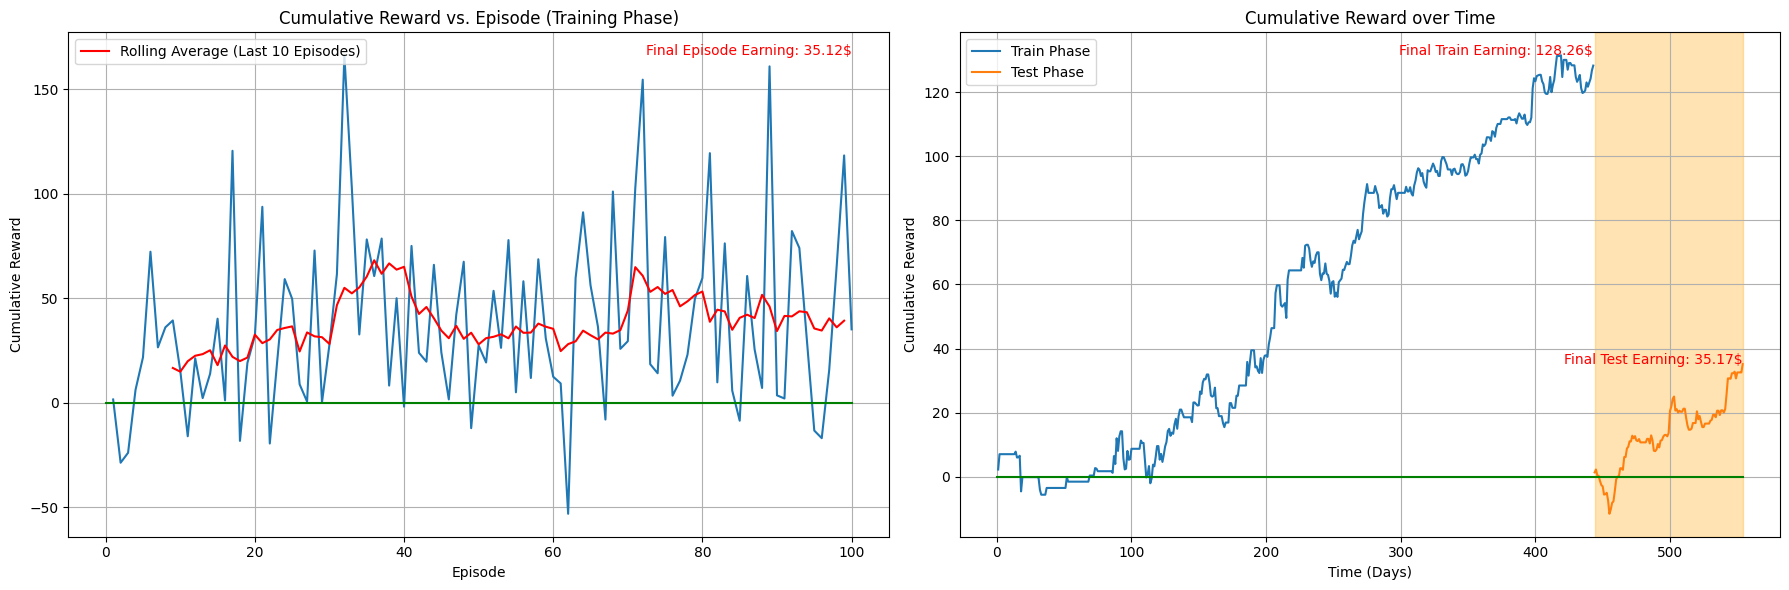

In [151]:
plot_predicted_values(episodes_rewards, train_rewards, test_rewards, stock_data_train, stock_data_test,max_display=False, log_y = False)

Let's put some perspective with the maximum achievable gains :

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


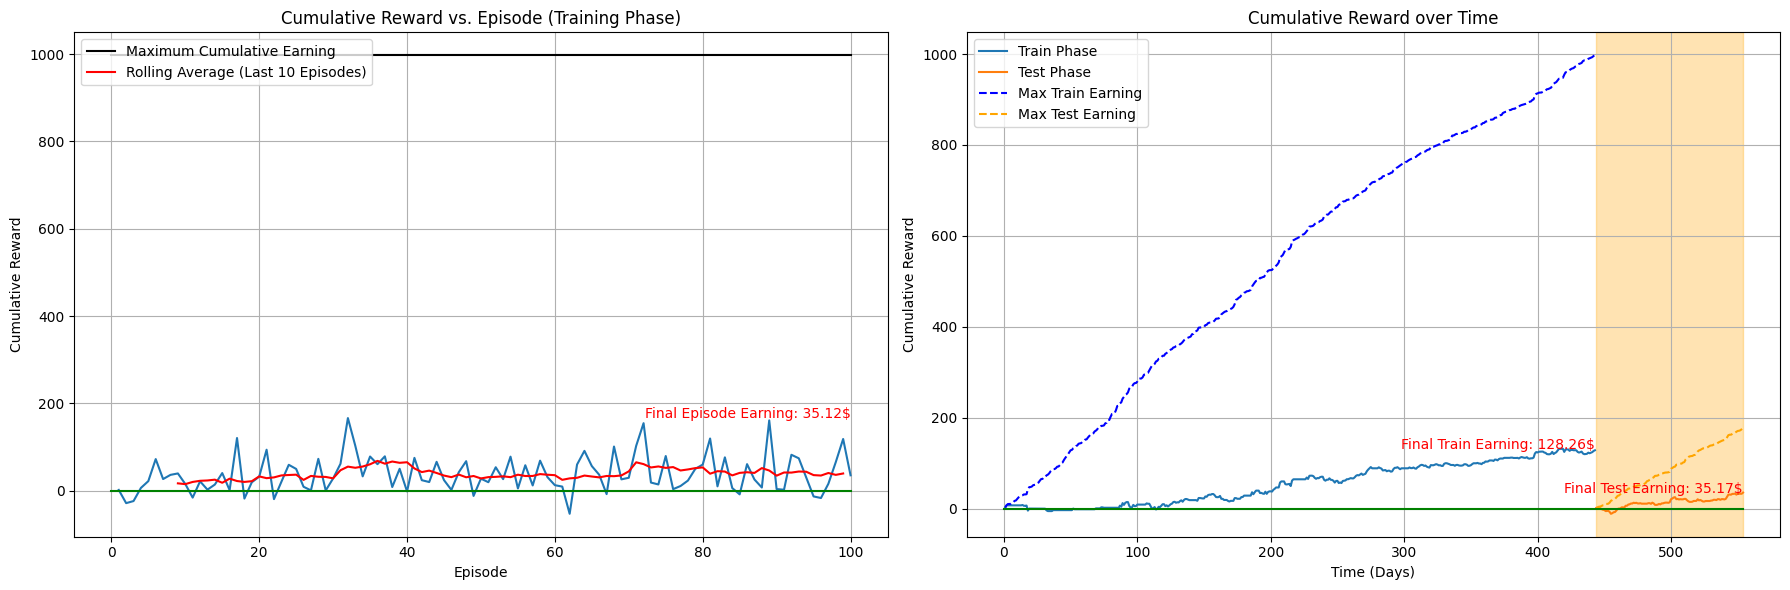

In [152]:
plot_predicted_values(episodes_rewards, train_rewards, test_rewards, stock_data_train, stock_data_test,max_display=True, log_y = False)

Haha we are far from the best agent ever !

### 20 days, 128 hidden size, 300 episodes, batch size 16

In [153]:
num_episodes=300

trained_agent,episodes_rewards,train_rewards,test_rewards=training_DQN_agent2(train_env=train_env,
                                         test_env=test_env,
                                         hidden_size=hidden_size,
                                        state_size=state_size,
                                        action_size=action_size,
                                        device=device,
                                        nn_learning_rate=nn_learning_rate,
                                        num_episodes=num_episodes,
                                        initial_epsilon=initial_epsilon,
                                        decay_rate=decay_rate,
                                        batch_size=batch_size,
                                        gamma=gamma,
                                        target_update_frequency=target_update_frequency)

Model architecture : 
QNetwork2(
  (fc1): Linear(in_features=3, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
)




100%|██████████| 300/300 [07:51<00:00,  1.57s/it]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


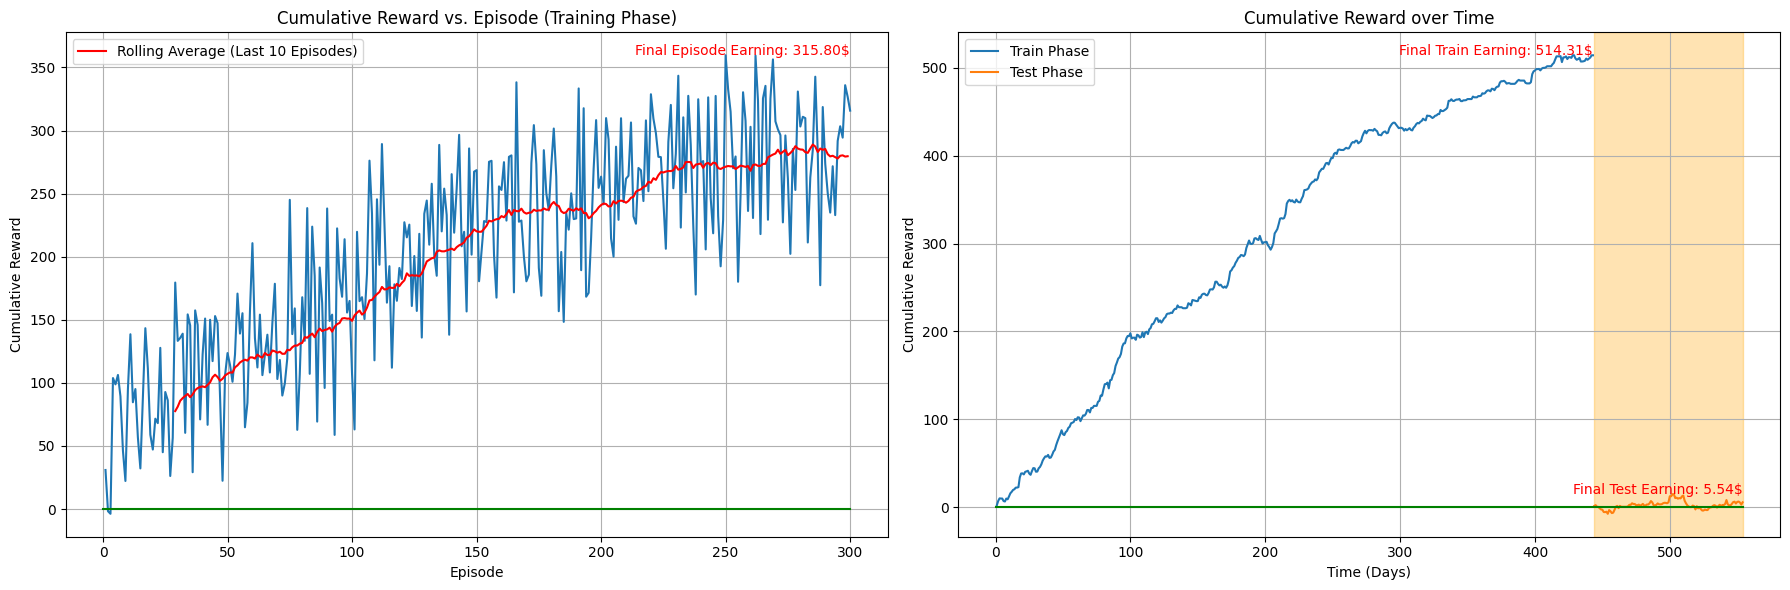

In [154]:
plot_predicted_values(episodes_rewards, train_rewards, test_rewards, stock_data_train, stock_data_test,max_display=False, log_y = False)

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


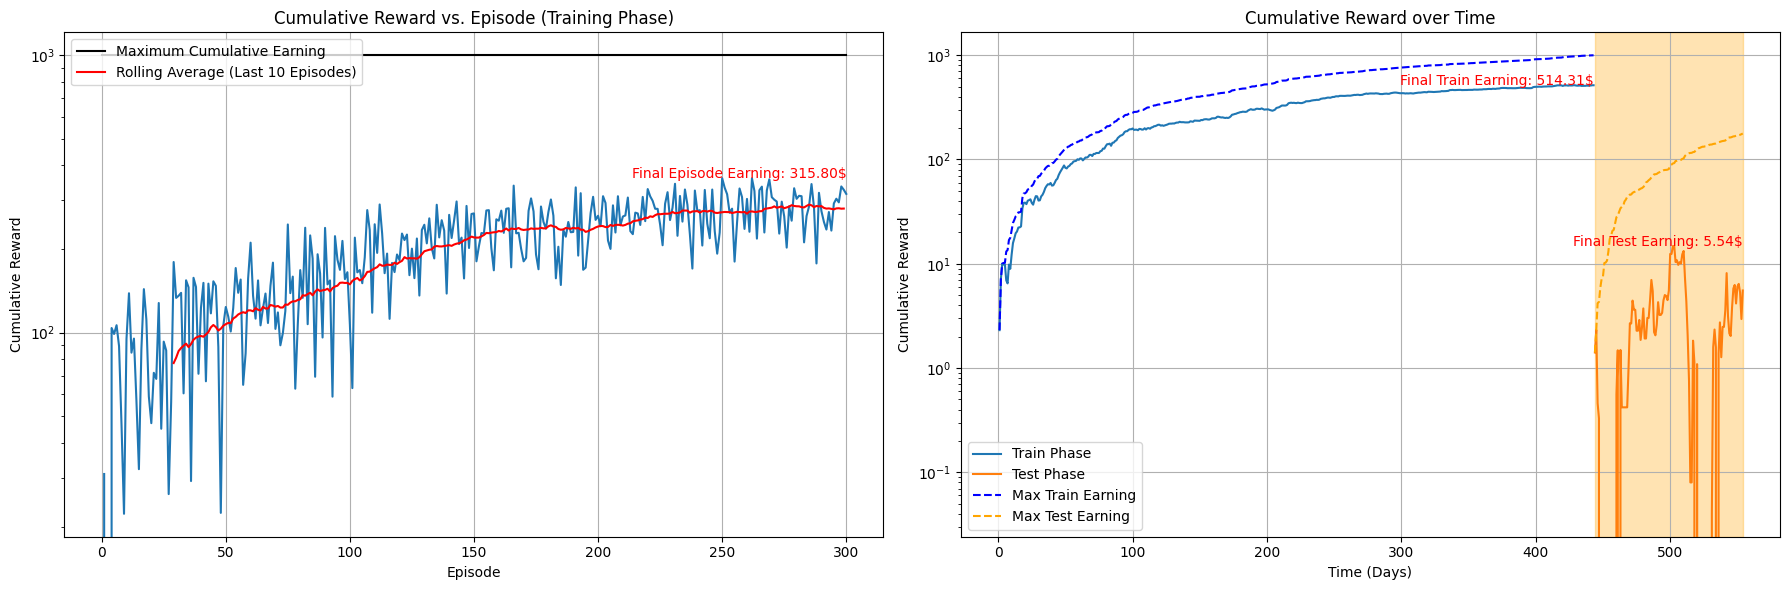

In [155]:
plot_predicted_values(episodes_rewards, train_rewards, test_rewards, stock_data_train, stock_data_test,max_display=True, log_y = True)

### 20 days, 128 hidden size, 300 episodes, batch size 32

In [156]:
num_episodes=300
batch_size=32

trained_agent,episodes_rewards,train_rewards,test_rewards=training_DQN_agent2(train_env=train_env,
                                         test_env=test_env,
                                         hidden_size=hidden_size,
                                        state_size=state_size,
                                        action_size=action_size,
                                        device=device,
                                        nn_learning_rate=nn_learning_rate,
                                        num_episodes=num_episodes,
                                        initial_epsilon=initial_epsilon,
                                        decay_rate=decay_rate,
                                        batch_size=batch_size,
                                        gamma=gamma,
                                        target_update_frequency=target_update_frequency)

Model architecture : 
QNetwork2(
  (fc1): Linear(in_features=3, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
)




100%|██████████| 300/300 [08:11<00:00,  1.64s/it]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


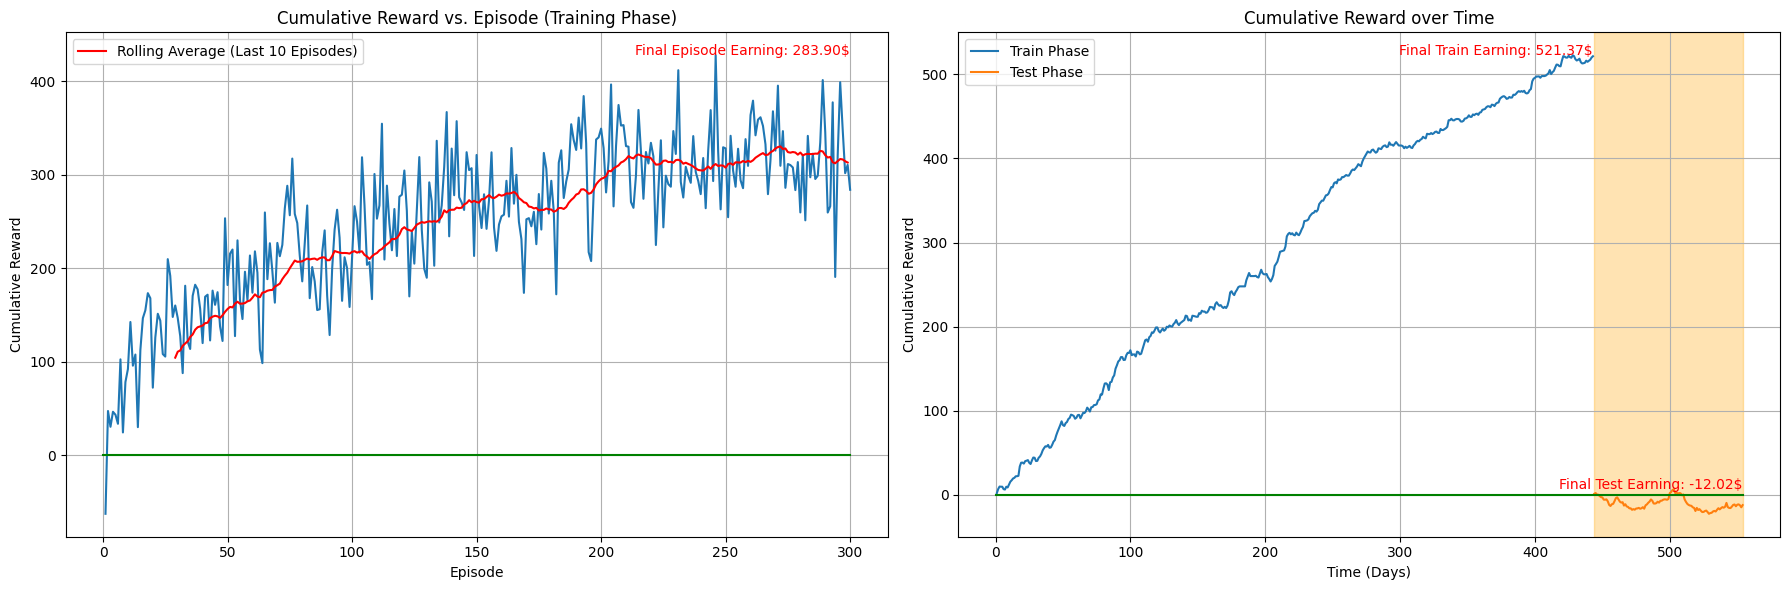

In [157]:
plot_predicted_values(episodes_rewards, train_rewards, test_rewards, stock_data_train, stock_data_test,max_display=False, log_y = False)

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


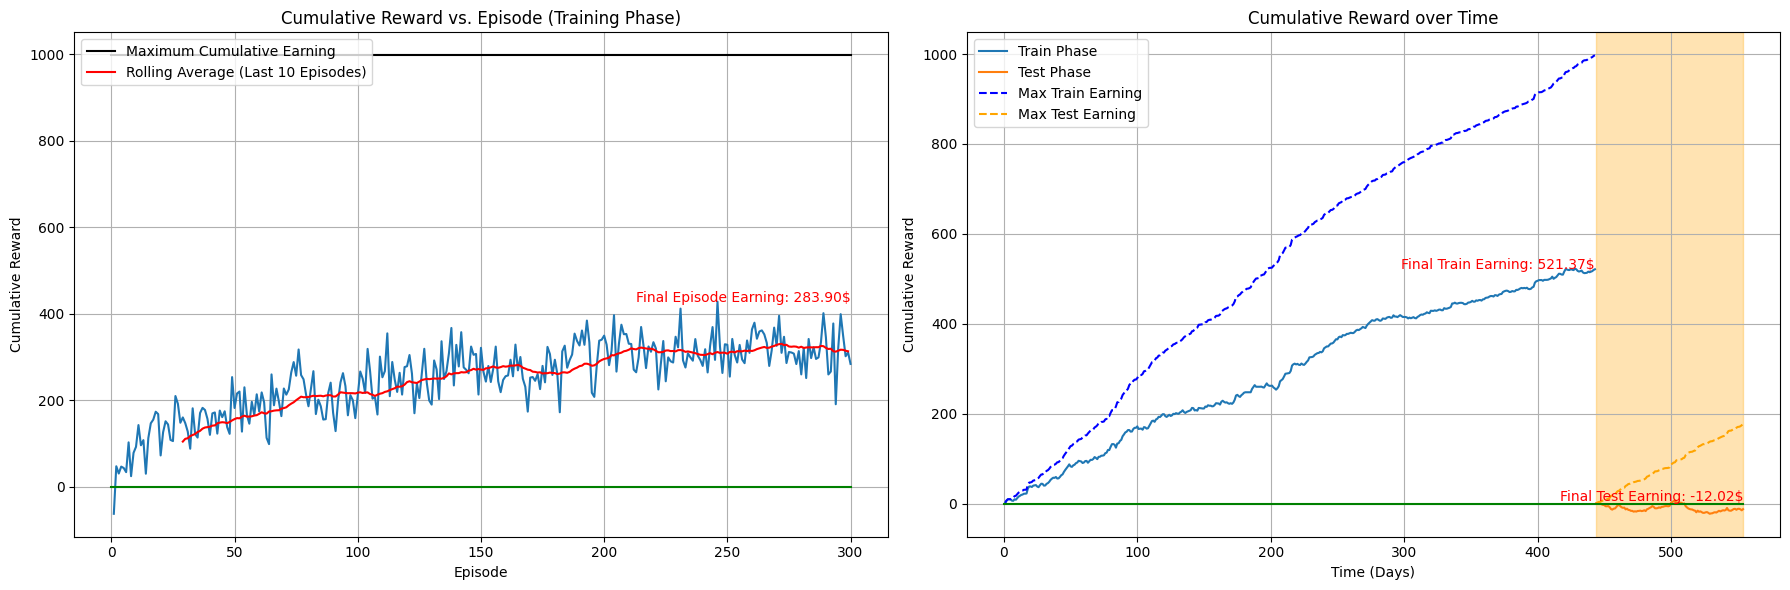

In [158]:
plot_predicted_values(episodes_rewards, train_rewards, test_rewards, stock_data_train, stock_data_test,max_display=True, log_y = False)

## Conclusion on the 2nd environment

The agent is clearly overfitting : the performance is really good on the training set, but on unseen data, it struggles.

# Env3 : (price, volume, moving avg, lag-1, lag-5)

Now, we add lags to our state space.

We just need to update get_state() to add lags.

### Class definition

In [159]:
class StockTradingEnv3(gym.Env):
    def __init__(self, df, last_n_days=5, price_scaler= None,volume_scaler = None, train = True ):
        super(StockTradingEnv3, self).__init__()

        """ Constructor for the StockTradingEnv3
        df[DataFrame] : dataframe with index and values
        last_n_days[int] : number of days we take into account to compute the moving average """

        # Preprocess data as we will use a NN approach
        self.df = df  # storing the df as it we will need its information for reset() and step()
        self.train = train

        self.close = df["Close"].values.reshape(-1, 1)
        self.volume = df["Volume"].values.reshape(-1, 1)

        self.close_scaler=price_scaler
        self.volume_scaler=volume_scaler

        if price_scaler==None : #if we are in the train preprocessing
          self.close_scaler = MinMaxScaler() #2 different scaler because we reuse the price scaler after on the moving average
          self.volume_scaler = MinMaxScaler()
          self.close_normalized = self.close_scaler.fit_transform(self.close)
          self.volume_normalized = self.volume_scaler.fit_transform(self.volume)
        else :
          self.close_normalized = self.close_scaler.transform(self.close)
          self.volume_normalized = self.volume_scaler.transform(self.volume)

        self.max_reward, self.min_reward = self.compute_reward_stats()

        self.state = None
        self.last_n_days = last_n_days

        # Action space: 0 = sell, 1 = hold, 2 = buy
        self.action_space = Discrete(3)

        # Observation space: current price, volume, mean, lag-1, lag-5
        self.observation_space = Box(low=0, high=1, shape=(5,))

    def reset(self):

        """Method to initiate a new episode.
        In our case, we need to define which day is the starting point from our data. """

        if self.train == True : #we start randomly in the data set only in the training phase
          self.current_step =  random.randrange(0,len(self.df)) #starting index for the current episode that will be updated in step()
        else : #in the test set, we begin from 0
          self.current_step=0

        self.num_remaining_values = len(self.df) - self.current_step  # storing the number or remaining epsiodes

        # Initialize reward statistics (optional)
        self.reward_mean = 0.0
        self.reward_std = 1.0  # Avoid division by zero initially
        self.count_step = 0  # to udpate the reward mean (is different than current step)

        return self.get_state()

    def get_moving_average(self):
        """ Function that computes the mean of prices for the last n days, and then normalize this value"""

        # Computing the mean of the previous values, and then normalizing this mean
        if self.current_step >= self.last_n_days:  # case we have enough day before to compute the mean

            # Extract the last n days of close prices
            price_last_n_days = self.close[self.current_step - self.last_n_days + 1:self.current_step + 1]

            # Compute the mean of the last n days
            moving_average = np.mean(price_last_n_days)

            # Normalize the mean using the same scaler
            normalized_moving_average = self.close_scaler.transform(np.array(moving_average).reshape(-1, 1))

        else:
            # If there are not enough previous days, use the current price as the mean
            normalized_moving_average = [self.close_normalized[self.current_step]]

        return normalized_moving_average[0][0]

    def compute_reward_stats(self):
        """
        This function computes the max, min and standard deviation of daily rewards

        Args:
            df: A pandas DataFrame with a 'value' column

        Returns:
            A dictionary containing the max reward, min reward and standard deviation of rewards
        """
        # Calculate daily rewards (absolute difference between consecutive values)
        rewards = self.df["Close"].diff().abs()

        # Compute max reward, min reward and standard deviation of rewards
        max_reward = rewards.max()
        min_reward = rewards.min()

        return max_reward, min_reward

    def get_state(self):
        # Get the current state representation

        current_price = self.close_normalized[self.current_step][0]  # getting the normalized price
        current_volume = self.volume_normalized[self.current_step][0]  # getting the normalized volume
        normalized_price_mean_last_n_days = self.get_moving_average()

        # Calculate lag-1 and lag-5 values
        lag_1_price = self.close_normalized[self.current_step - 1][0] if self.current_step > 0 else current_price
        lag_5_price = self.close_normalized[self.current_step - 5][0] if self.current_step > 4 else current_price

        return current_price, current_volume, normalized_price_mean_last_n_days, lag_1_price, lag_5_price

    def step(self, action):

        """
        Given an action it returns
        * an observation
        * a reward
        * a status report if the game is over
        * an info dictionary
        """

        # Calculate next state
        self.current_step += 1
        self.count_step += 1
        next_state = self.get_state()  # 5 values to unpack

        # Calculate reward
        current_price = self.close[self.current_step][0]  # we take the non normalized value to compute the reward
        previous_price = self.close[self.current_step - 1][0]

        if action == 0:  # Sell
            reward = previous_price - current_price
        elif action == 1:  # hold
            reward = 0  # No change in price when holding
        else:  # Buy
            reward = current_price - previous_price

        # Normalize the reward
        normalized_reward = (reward - self.min_reward) / (self.max_reward - self.min_reward)

        # Update state
        self.state = next_state

        # Check if episode is done
        done = self.current_step == len(self.df) - 1

        return next_state, normalized_reward, done, {"reward": reward}

    def render(self, mode='human'):
        pass


### Example usage

In [160]:
# Create custom Gym environment
env = StockTradingEnv3(stock_data, last_n_days=10)

# Example usage
obs = env.reset()
print("First observation", obs, "on day", env.current_step , "out of ", len(stock_data))
print(f"There are {env.num_remaining_values} values in the df. ")

for _ in range(5):
    print("\n")

    action = env.action_space.sample()  # Random action for demonstration
    print("Action taken", action)

    next_obs, reward, done, _ = env.step(action)
    print("next_obs: ", next_obs, "normalized reward: ", reward, "done: ", done, _)

    if done:
        break

First observation (0.47995632174477554, 0.16451713205052923, 0.5212478052052532, 0.4895335130191871, 0.5556164459632946) on day 319 out of  556
There are 237 values in the df. 


Action taken 2
next_obs:  (0.5546586224522974, 0.28001427907390364, 0.5278013597628324, 0.47995632174477554, 0.5300314100558736) normalized reward:  0.45499928792317706 done:  False {'reward': 5.459991455078125}


Action taken 2
next_obs:  (0.549870131198648, 0.15980831730826842, 0.5317006701319922, 0.5546586224522974, 0.5423451206376415) normalized reward:  -0.029165903727213543 done:  False {'reward': -0.3499908447265625}


Action taken 0
next_obs:  (0.5501436161156936, 0.11017024515984172, 0.5321521707656525, 0.549870131198648, 0.5063620211704467) normalized reward:  -0.0016657511393229167 done:  False {'reward': -0.019989013671875}


Action taken 2
next_obs:  (0.5671090754925887, 0.1631920289466597, 0.5325626277850446, 0.5501436161156936, 0.4895335130191871) normalized reward:  0.1033337910970052 done:  Fa

## Training sessions

### 20 days, 128 hidden size, 100 episodes, batch size 16

In [161]:
last_n_days=20

stock_data_train  = stock_data[:int(len(stock_data)*0.8)]
stock_data_test  = stock_data[int(len(stock_data)*0.8):]

train_env = StockTradingEnv3(stock_data_train,last_n_days=last_n_days, price_scaler = None,volume_scaler=None, train = True)
test_env = StockTradingEnv3(stock_data_test, last_n_days=last_n_days,price_scaler = train_env.close_scaler,volume_scaler = train_env.volume_scaler, train = False)

state_size= 5 #price, volume, moving average, lag-1, lag-5
action_size= env.action_space.n

hidden_size=128
nn_learning_rate=0.001
num_episodes=100
initial_epsilon=0.4 #Typical values: 0.1 to 0.5
decay_rate=0.995
batch_size=16 #Typical values: 32 to 256
gamma=0.95 #Typical values: 0.95 to 0.99
target_update_frequency=20 #Typical values: 1000 to 10000 (number of steps)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trained_agent,episodes_rewards,train_rewards,test_rewards=training_DQN_agent2(train_env=train_env,
                                         test_env=test_env,
                                         hidden_size=hidden_size,
                                        state_size=state_size,
                                        action_size=action_size,
                                        device=device,
                                        nn_learning_rate=nn_learning_rate,
                                        num_episodes=num_episodes,
                                        initial_epsilon=initial_epsilon,
                                        decay_rate=decay_rate,
                                        batch_size=batch_size,
                                        gamma=gamma,
                                        target_update_frequency=target_update_frequency)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Model architecture : 
QNetwork2(
  (fc1): Linear(in_features=5, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
)




100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


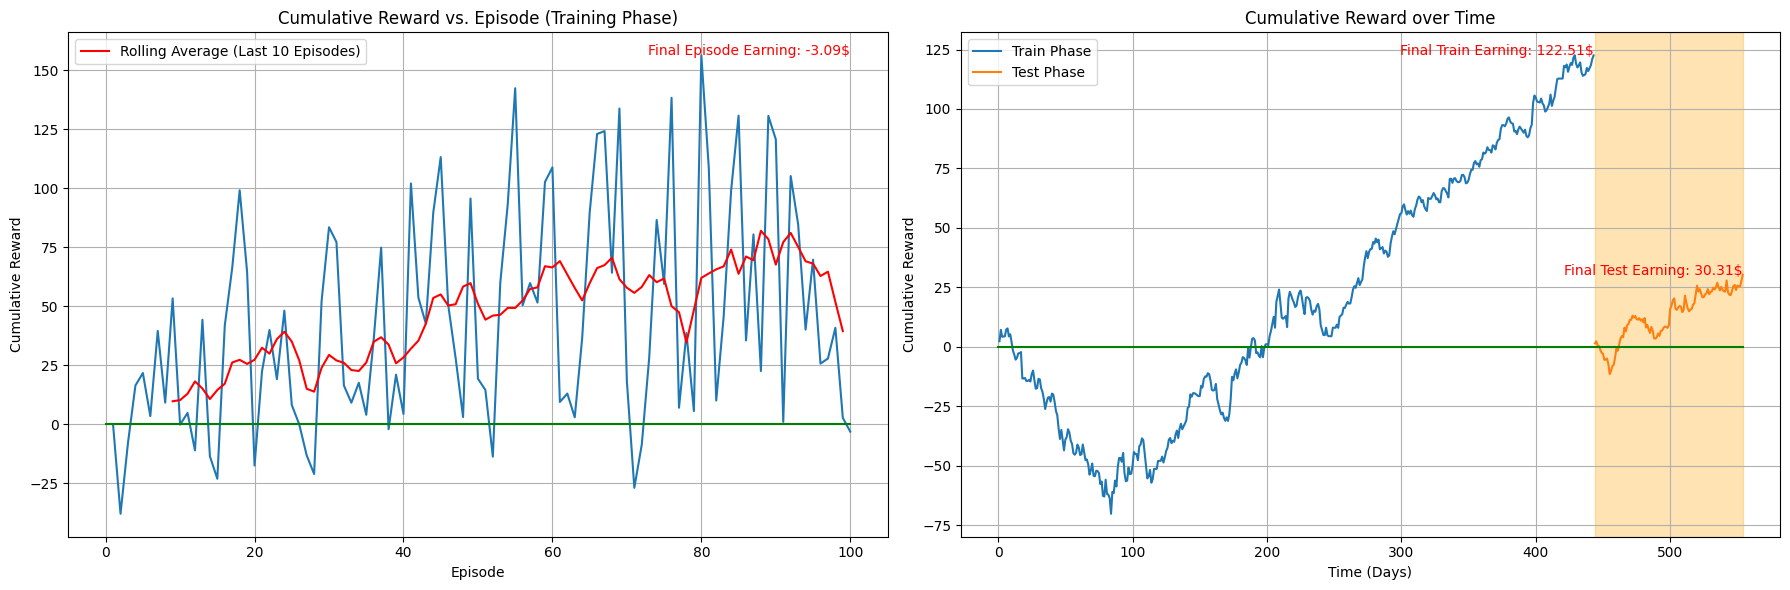

In [162]:
plot_predicted_values(episodes_rewards, train_rewards, test_rewards, stock_data_train, stock_data_test,max_display=False, log_y = False)

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


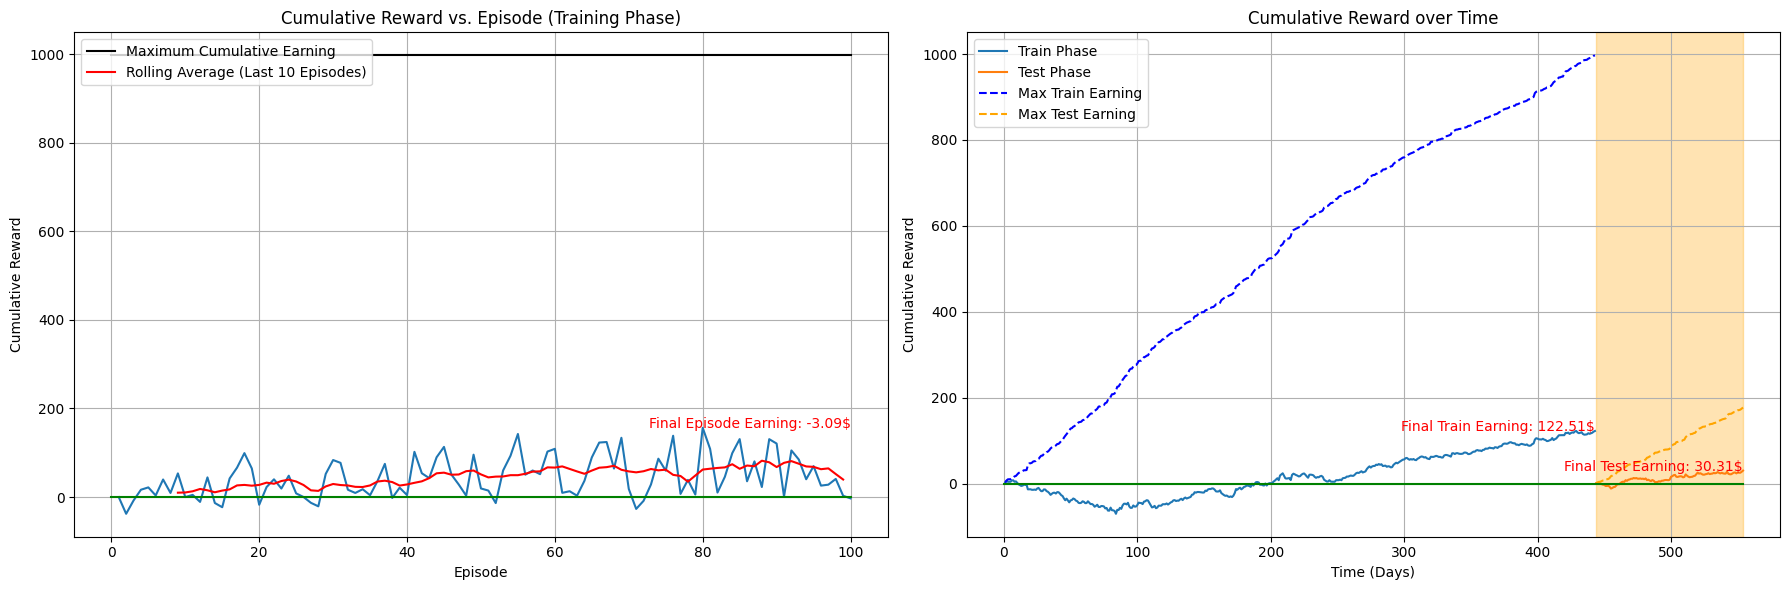

In [163]:
plot_predicted_values(episodes_rewards, train_rewards, test_rewards, stock_data_train, stock_data_test,max_display=True, log_y = False)

### 20 days, 128 hidden size, 300 episodes, batch size 16

In [164]:
num_episodes=300

trained_agent,episodes_rewards,train_rewards,test_rewards=training_DQN_agent2(train_env=train_env,
                                         test_env=test_env,
                                         hidden_size=hidden_size,
                                        state_size=state_size,
                                        action_size=action_size,
                                        device=device,
                                        nn_learning_rate=nn_learning_rate,
                                        num_episodes=num_episodes,
                                        initial_epsilon=initial_epsilon,
                                        decay_rate=decay_rate,
                                        batch_size=batch_size,
                                        gamma=gamma,
                                        target_update_frequency=target_update_frequency)

Model architecture : 
QNetwork2(
  (fc1): Linear(in_features=5, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
)




100%|██████████| 300/300 [08:00<00:00,  1.60s/it]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


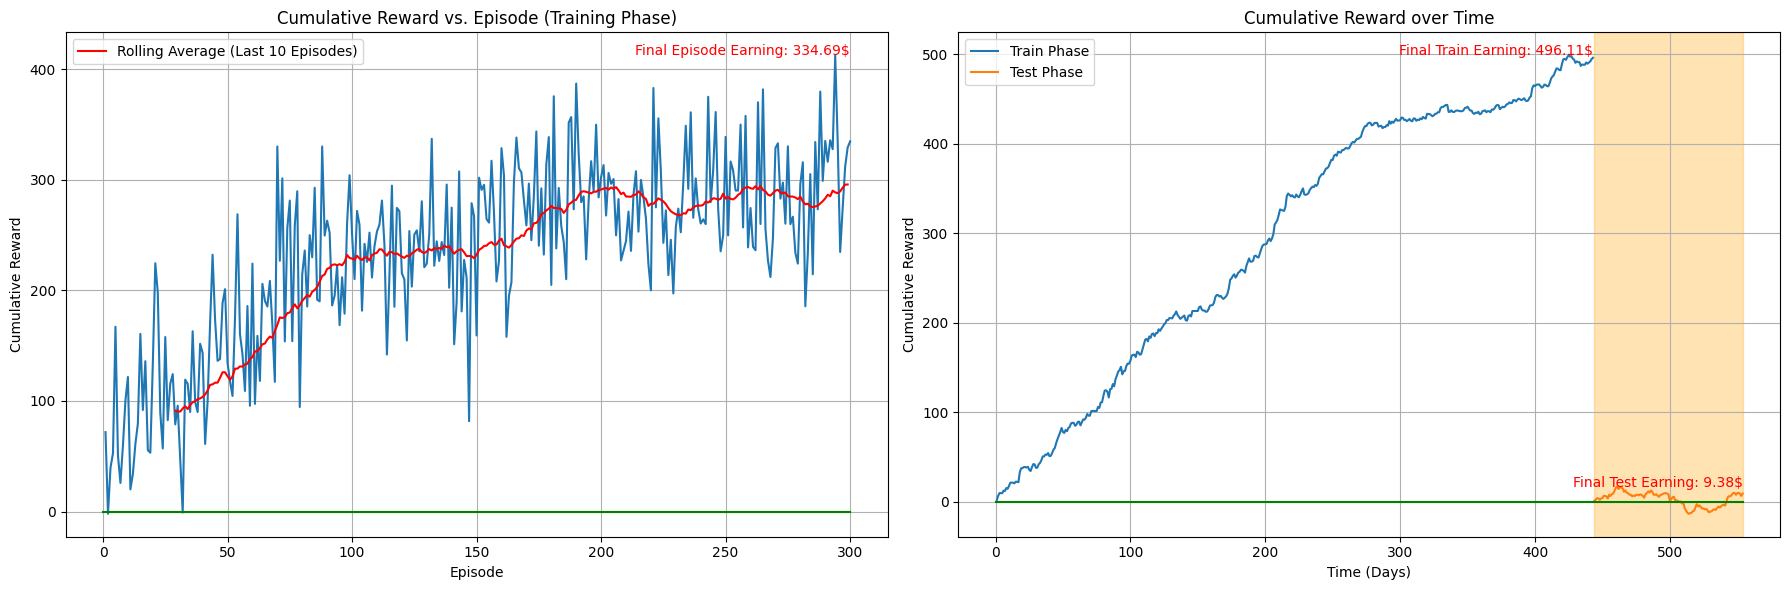

In [165]:
plot_predicted_values(episodes_rewards, train_rewards, test_rewards, stock_data_train, stock_data_test,max_display=False, log_y = False)

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


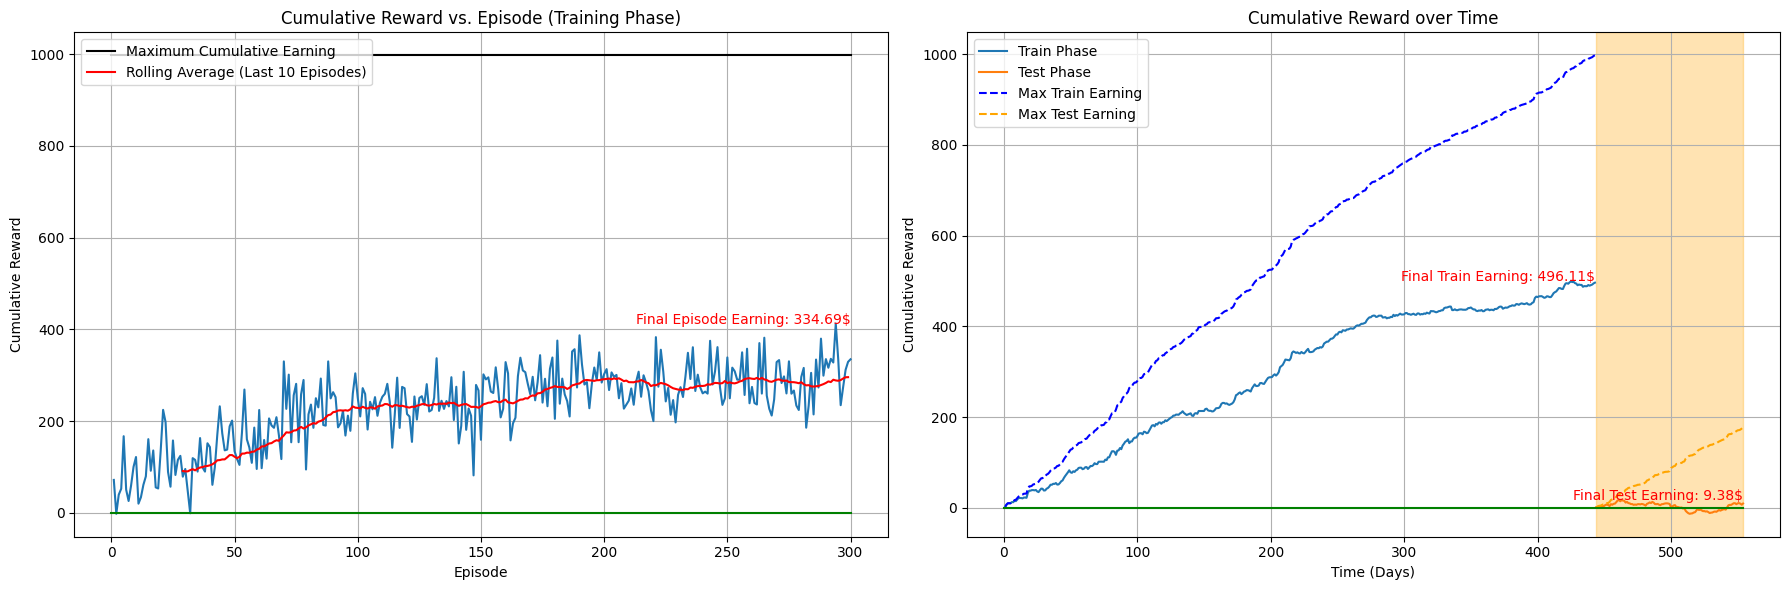

In [166]:
plot_predicted_values(episodes_rewards, train_rewards, test_rewards, stock_data_train, stock_data_test,max_display=True, log_y = False)

### 20 days, 128 hidden size, 300 episodes, batch size 32

In [168]:
num_episodes=300
batch_size=32

trained_agent,episodes_rewards,train_rewards,test_rewards=training_DQN_agent2(train_env=train_env,
                                         test_env=test_env,
                                         hidden_size=hidden_size,
                                        state_size=state_size,
                                        action_size=action_size,
                                        device=device,
                                        nn_learning_rate=nn_learning_rate,
                                        num_episodes=num_episodes,
                                        initial_epsilon=initial_epsilon,
                                        decay_rate=decay_rate,
                                        batch_size=batch_size,
                                        gamma=gamma,
                                        target_update_frequency=target_update_frequency)

Model architecture : 
QNetwork2(
  (fc1): Linear(in_features=5, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
)




100%|██████████| 300/300 [08:11<00:00,  1.64s/it]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


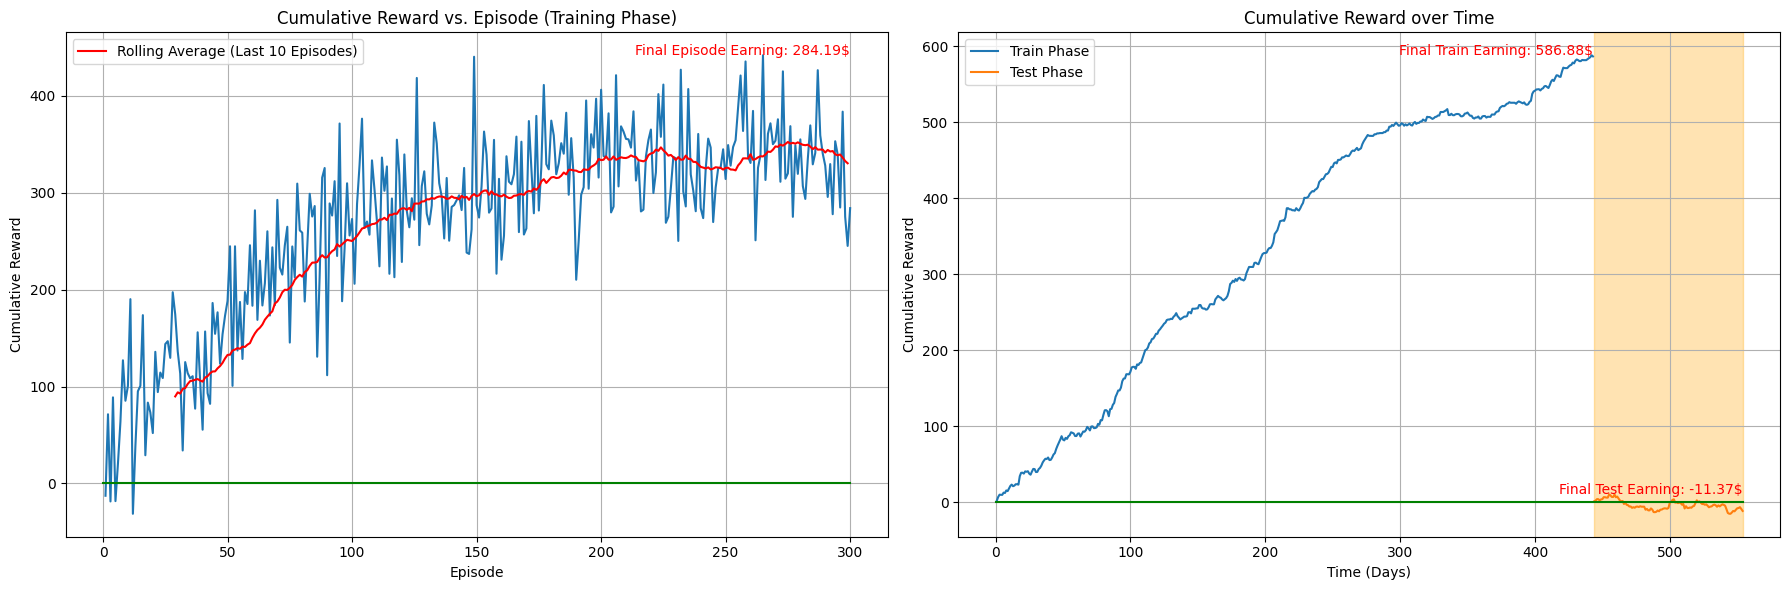

In [169]:
plot_predicted_values(episodes_rewards, train_rewards, test_rewards, stock_data_train, stock_data_test,max_display=False, log_y = False)

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


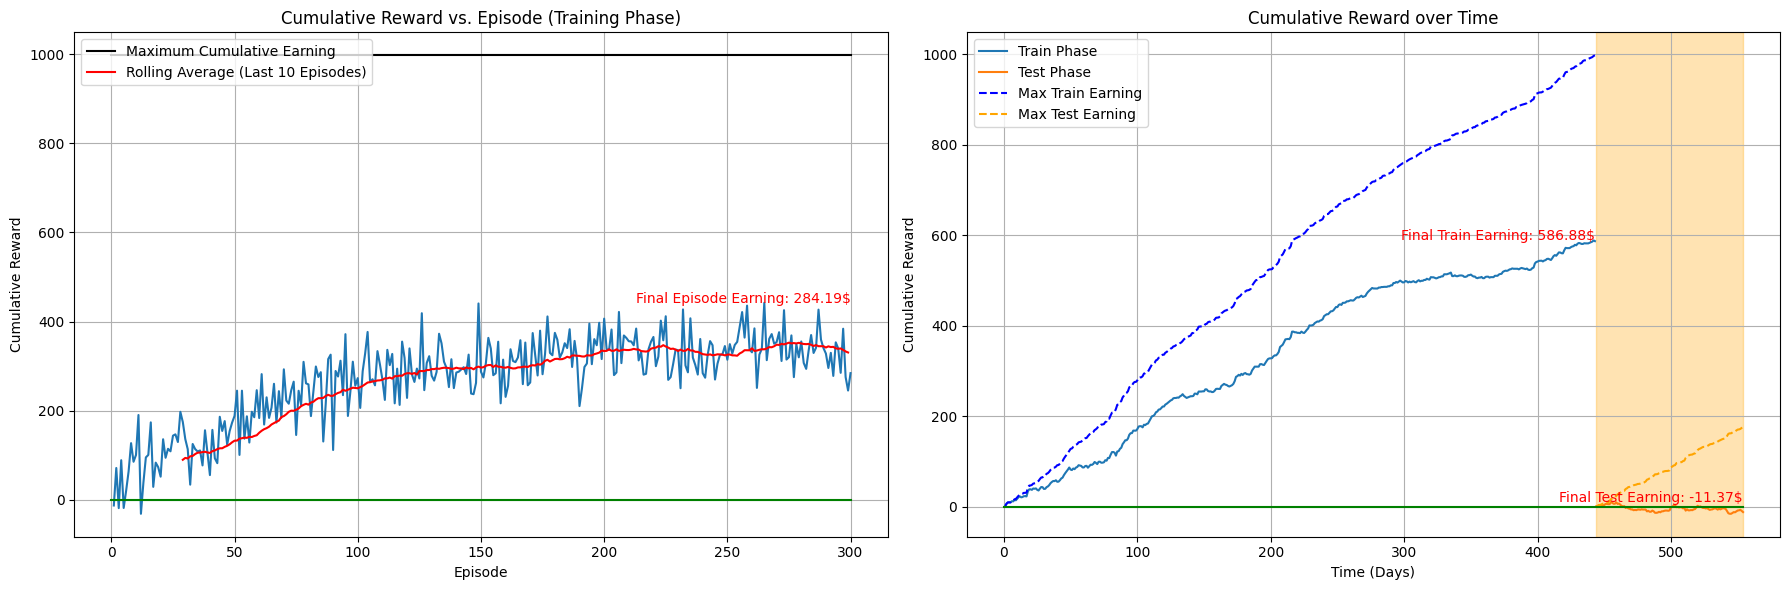

In [170]:
plot_predicted_values(episodes_rewards, train_rewards, test_rewards, stock_data_train, stock_data_test,max_display=True, log_y = False)

### Conclusion on the 3nd environment

Adding 2 more states dimensions doesn't help on the test set. The agent learns very well on the train set as expected, but the overfitting is too high.

# Result Board

- The decay rate is always 0.995
- gamma is always 0.95

num_episodes | state_size | hidden_size | learning_rate | last_n_days | epsilon  | batch | gamma | update frequency | last cumulated reward
--- | --- | --- | --- | --- | --- | --- | --- | --- | ---
100 | 1 | 16 | 0.001 | NA | 0.4 | 16 | 0.95 | 20 | -0.20\$
1k | 1 | 16 | 0.001 | NA | 0.4 | 16 | 0.95 | 20 | -1.20\$
1k | 1 | 128 | 0.001 | NA | 0.4 | 16 | 0.95 | 100 | 1.09\$
100 | 3 | 128 | 0.001 | 20 | 0.4 | 16 | 0.95 | 20 | 132.03\$
300 | 3 | 128 | 0.001 | 20 | 0.4 | 16 | 0.95 | 20 | 118.65\$
100 | 5 | 128 | 0.001 | 20 | 0.4 | 16 | 0.95 | 20 | 10.45\$
300 | 5 | 128 | 0.001 | 20 | 0.4 | 16 | 0.95 | 20 | 75.61\$
300 | 5 | 128 | 0.001 | 20 | 0.4 | 32 | 0.95 | 20 | 71.45\$

# Policy display & Money Spent

Here, we want to see how the actions taken by the agent over time, after being trained. Plus, we plot the value of the portfolio, to see if in real life, we could afford such transactions, remembering that the agent can only buy or sell 1 stock a day.

In [190]:
def plot_stock_with_agent_decisions(env, df, trained_agent):

    # Get the stock values
    prices = df["Close"].values

    # Initialize figure and subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot stock values
    data = df.copy()
    data["Date"] = pd.to_datetime(data.index)
    ax1.plot(data["Date"], data["Close"], linestyle='solid', marker=None)

    # Initialize portfolio value
    portfolio_value = 10000
    portfolio_values = []

    env.current_step = 0 # to see the policy for each point
    env.count_step = 0
    state = env.get_state() # initial state
    state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
    batch_tensor = state_tensor.unsqueeze(0).repeat(2, 1).to(device) # need of a batch and not a single input

    # Plot agent decisions
    for i in range(len(prices)-1):
        output = trained_agent.q_network(batch_tensor).to(device)
        action = torch.argmax(output[0]).item()

        state, _, _, info_dict = env.step(action)

        # Update portfolio value based on action
        if action == 0:  # Sell
            portfolio_value += prices[i]
        elif action == 2:  # Buy
            portfolio_value -= prices[i]

        portfolio_values.append(portfolio_value)

        state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
        batch_tensor = state_tensor.unsqueeze(0).repeat(2, 1).to(device)

        if action == 0:  # Sell
            ax1.scatter(df.index[i], prices[i], color='red', marker='v', label='Sell' if i == 0 else '')
        elif action == 1:  # Hold
            ax1.scatter(df.index[i], prices[i], color='green', marker='o', label='Hold' if i == 0 else '')
        elif action == 2:  # Buy
            ax1.scatter(df.index[i], prices[i], color='orange', marker='^', label='Buy' if i == 0 else '')

    # Add legend and labels
    ax1.legend(loc='upper left')
    ax1.set_xlabel('Day')
    ax1.set_ylabel('Stock Price')
    ax1.set_title('Stock Prices with Agent Decisions')
    ax1.grid(True)

    # Plot portfolio value over time
    ax2.plot(df.index[:-1], portfolio_values, linestyle='dashed', marker=None, color='blue',label="Portfolio's Value")
    ax2.plot(df.index[:-1], [10000 for i in range(len(df.index[:-1]))], linestyle='dashed', marker=None, color='green', label="Initial Portfolio's Value")
    ax2.set_ylabel('Portfolio Value', color='blue')

    # Add legend
    ax1.legend(['Stock Price'], loc='upper left')
    ax2.legend(loc='upper right')

    # Add title
    plt.title('Stock Prices with Portfolio Value')

    # Show plot
    plt.show()


In [ ]:
stock_data_train  = stock_data[:int(len(stock_data)*0.8)]
stock_data_test  = stock_data[int(len(stock_data)*0.8):]

train_env = StockTradingEnv3(stock_data_train,last_n_days=last_n_days, price_scaler = None,volume_scaler=None, train = True)
test_env = StockTradingEnv3(stock_data_test, last_n_days=last_n_days,price_scaler = train_env.close_scaler,volume_scaler = train_env.volume_scaler, train = False)


## Policy on the train set

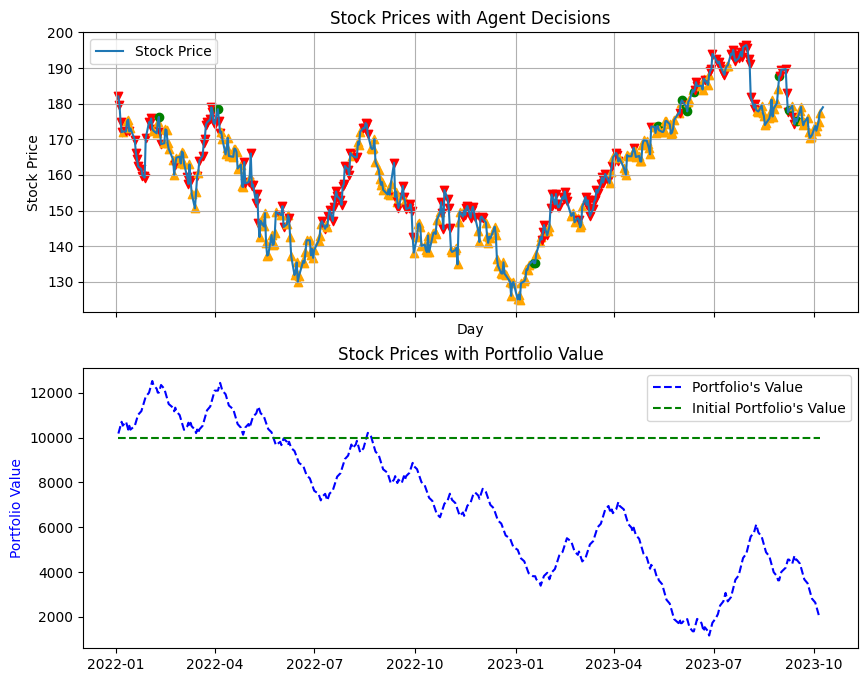

In [192]:
plot_stock_with_agent_decisions(train_env,stock_data_train, trained_agent)

## Policy on the test set

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



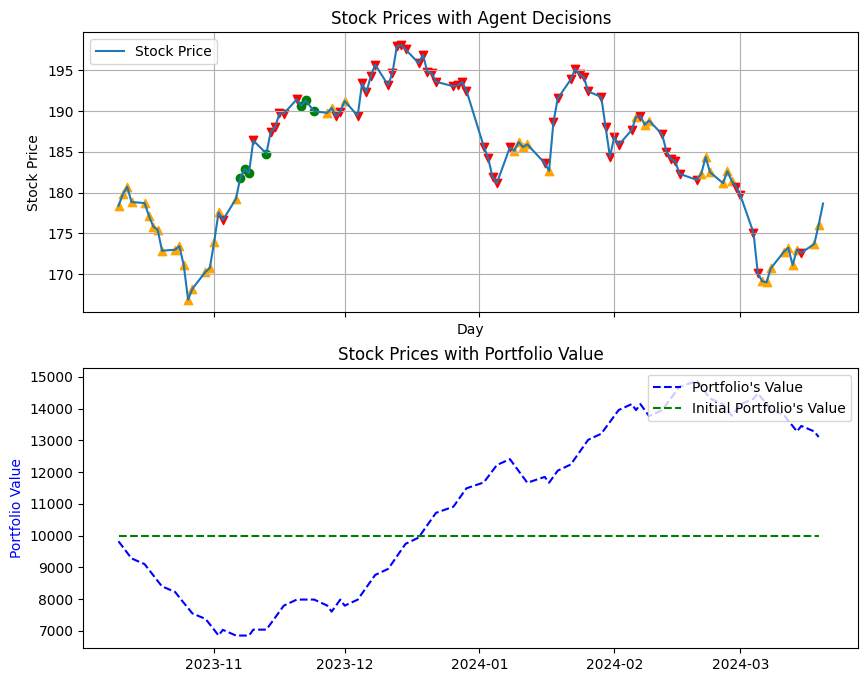

In [193]:
plot_stock_with_agent_decisions(test_env,stock_data_test, trained_agent)

Beginning with 10k \$, the portfolio's value is not aberrant.

# Overall Conclusion

- Our agent learns very well on the train set, and the more information it has (going from 1 to 3 to 5 dimensions in the state space), the better the results are
- We can't have a clear positive trend on the test set. Learning only for the time series itself is not enough. More external factor might help, such as GPD, market sentiment, etc...
- Other Neural Network might help: here , we tried to capture the past values with a rolling average and lags, but a LSTM could have been better, maybe.

*Even if I loved this project, I would never lend my money to any of these agents !*